In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns

%matplotlib inline

import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

In [3]:
# read data
data = pd.read_csv('../../clean_data/further_clean_new.csv', index_col=0)

In [4]:
data.head()

,MBTI,comments,comments_lemma
0,INFP,Lol that's why I left.,lol that be why leave
1,INTP,"I was just about to post ""I try telling people...",be just about to post try tell people all the ...
2,INFP,My first thought was Pepsi or something. Proba...,first thought be pepsi or something probably n...
3,ENTP,"Not if the formula is something like ""every ti...",not if the formula be something like every tim...
4,INTP,Does this imply I'm a five now?,do this imply be five now


In [7]:
# remember to drop na
data = data.dropna()

In [8]:
data.isna().sum()

MBTI              0
comments          0
comments_lemma    0
dtype: int64

In [9]:
data = data.drop(['comments'], axis=1).copy()

In [11]:
data.to_csv('clean20191207.csv')

In [61]:
data_test = data.sample(n=1000)

## Max DF & Min DF 

In [5]:
# list of posts 
[p.split('|||') for p in data.head(1).comments_lemma.values]

[['lol that be why leave']]

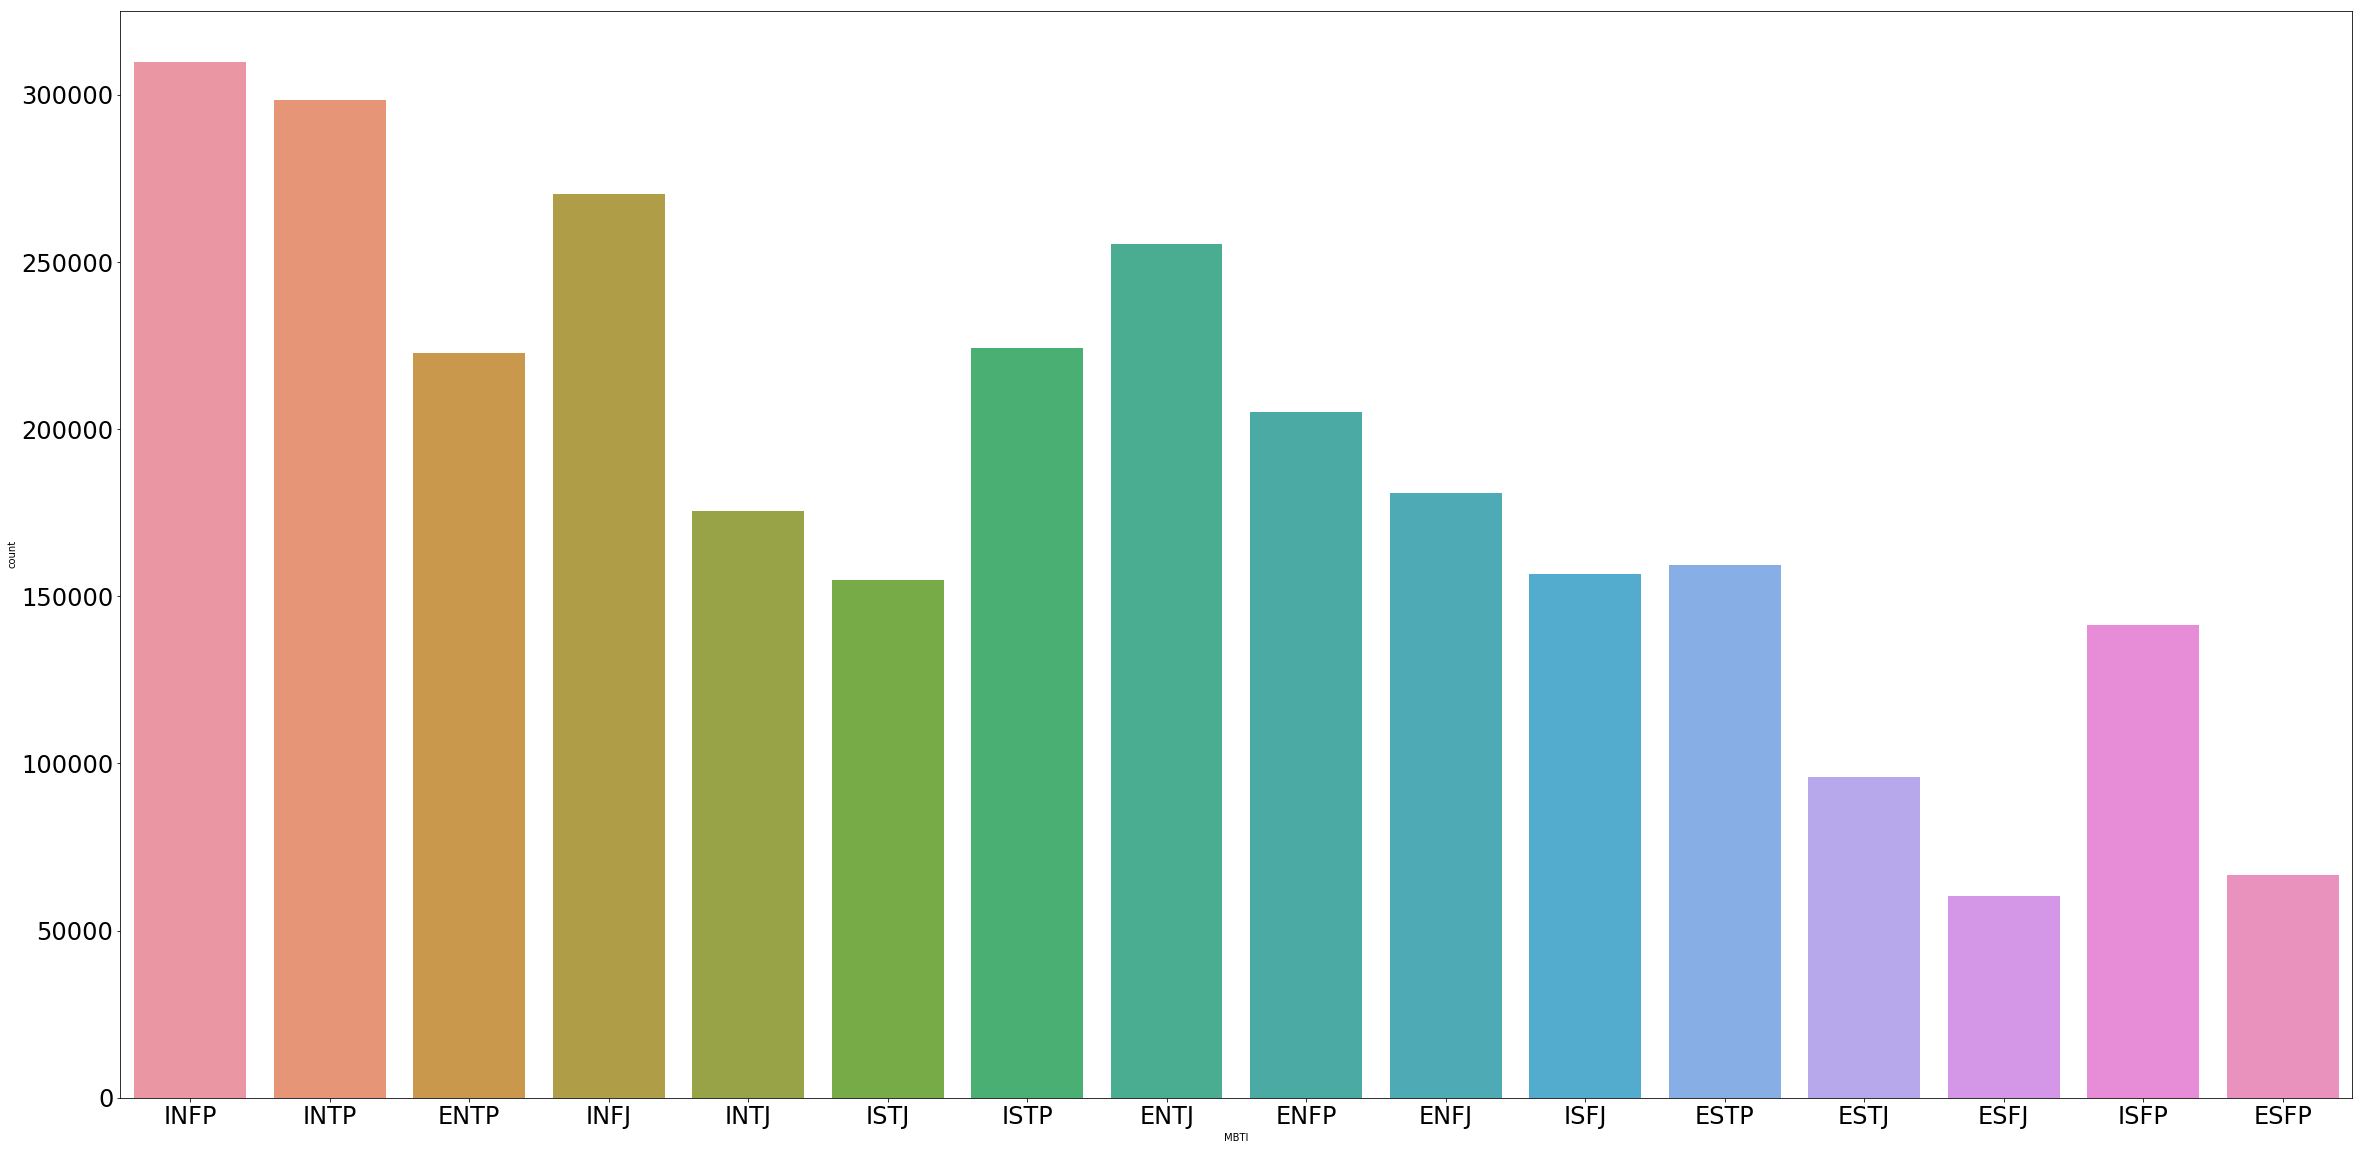

In [7]:
# distribution of data 

plt.figure(figsize=(40,20))
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=data, x='MBTI')

In [8]:
##### Encode each type to an int

from sklearn.preprocessing import LabelEncoder

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder = LabelEncoder().fit(unique_type_list)

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [306]:
# convert columns to list 

list_personality = data_test['MBTI'].tolist()
list_posts = data_test['comments_lemma'].apply(lambda x: ' '.join(x))

In [307]:
# Vectorize with count and tf-idf
# keep the words appearing in 10 to 50% of the posts.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#cntizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, ngram_range=(1,1), max_df=0.5, min_df=0.1) 

tfidfizer = TfidfVectorizer(tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
#                             ngram_range=(1,1),
                             max_df=0.9,
                             min_df=1000) 

#X_cnt = cntizer.fit_transform(list_posts).toarray()                                 
X_tfidf = tfidfizer.fit_transform(list_posts).toarray()

In [46]:
tfidfizer.vocabulary_

{'lol': 2527,
 'that': 4327,
 'be': 383,
 'why': 4756,
 'leave': 2452,
 'just': 2368,
 'about': 4,
 'to': 4396,
 'post': 3244,
 'try': 4483,
 'tell': 4292,
 'people': 3106,
 'all': 128,
 'the': 4328,
 'time': 4383,
 'always': 149,
 'joke': 2346,
 'unless': 4552,
 'say': 3732,
 'serious': 3808,
 'right': 3639,
 'now': 2912,
 'and': 175,
 'still': 4113,
 'do': 1262,
 'not': 2904,
 'catch': 650,
 'on': 2966,
 'but': 588,
 'here': 1997,
 'have': 1969,
 'already': 139,
 'figure': 1653,
 'out': 3014,
 'secret': 3773,
 'like': 2492,
 'know': 2398,
 'first': 1669,
 'thought': 4357,
 'or': 2994,
 'something': 3994,
 'probably': 3318,
 'alcohol': 119,
 'if': 2101,
 'formula': 1726,
 'every': 1496,
 'add': 56,
 'then': 4333,
 'would': 4813,
 'this': 4351,
 'imply': 2133,
 'five': 1675,
 'well': 4726,
 'think': 4347,
 'there': 4339,
 'lot': 2544,
 'of': 2951,
 'potential': 3248,
 'technology': 4286,
 'develop': 1168,
 'in': 2148,
 'image': 2115,
 'awareness': 329,
 'can': 612,
 'camera': 608,
 'de

## LDA

In [42]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Gensim

### 1. Create a Dictionary 

In [62]:
import gensim
from gensim import corpora
from pprint import pprint

# How to create a dictionary from a list of sentences?
documents = data_test['comments_lemma'].tolist( )

# Tokenize(split) the sentences into words
texts = [[text for text in doc.split()] for doc in documents]

# Create dictionary
dictionary = corpora.Dictionary(texts)

# Get information about the dictionary
print(dictionary)
#> Dictionary(33 unique tokens: ['Saudis', 'The', 'a', 'acknowledge', 'are']...)

Dictionary(5549 unique tokens: ['atom', 'be', 'over', 'talos', 'watch']...)


In [63]:
print(dictionary.token2id)

{'atom': 0, 'be': 1, 'over': 2, 'talos': 3, 'watch': 4, 'appreciate': 5, 'awesome': 6, 'dude': 7, 'hard': 8, 'job': 9, 'work': 10, 'at': 11, 'bear': 12, 'brown': 13, 'canyon': 14, 'detailed': 15, 'gas': 16, 'grand': 17, 'have': 18, 'little': 19, 'near': 20, 'of': 21, 'one': 22, 'pick': 23, 'shitty': 24, 'station': 25, 'summer': 26, 'the': 27, 'this': 28, 'those': 29, 'tiny': 30, 'up': 31, 'very': 32, 'absolutely': 33, 'after': 34, 'and': 35, 'beneficial': 36, 'both': 37, 'but': 38, 'challenge': 39, 'company': 40, 'could': 41, 'deserve': 42, 'do': 43, 'emotionally': 44, 'example': 45, 'few': 46, 'for': 47, 'get': 48, 'guess': 49, 'if': 50, 'imo': 51, 'in': 52, 'increase': 53, 'intent': 54, 'last': 55, 'leave': 56, 'mail': 57, 'malicious': 58, 'manager': 59, 'manipulate': 60, 'month': 61, 'never': 62, 'no': 63, 'not': 64, 'on': 65, 'only': 66, 'other': 67, 'people': 68, 'possible': 69, 'probably': 70, 'project': 71, 'really': 72, 'repetitive': 73, 'right': 74, 'send': 75, 'something': 76

### Create a Corpus 

In [64]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in documents]

# Create the Corpus
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]
pprint(mycorpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)],
 [(11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 2)],
 [(1, 8),
  (18, 1),
  (21, 2),
  (22, 1),
  (27, 3),
  (33, 1),
  (34, 1),
  (35, 4),
  (36, 2),
  (37, 1),
  (38, 3),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 4),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 2),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 2),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 5),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 6),
  (85, 1),
  (86, 1),
  (87, 1),
  (

  (738, 1),
  (739, 1),
  (740, 1),
  (741, 1),
  (742, 1),
  (743, 1),
  (744, 1),
  (745, 1),
  (746, 1),
  (747, 1),
  (748, 1),
  (749, 1),
  (750, 1),
  (751, 1),
  (752, 1)],
 [(18, 1),
  (27, 2),
  (31, 1),
  (47, 1),
  (52, 2),
  (84, 2),
  (134, 1),
  (171, 1),
  (205, 1),
  (217, 1),
  (373, 1),
  (495, 1),
  (753, 1),
  (754, 1),
  (755, 1),
  (756, 1),
  (757, 1),
  (758, 1),
  (759, 1),
  (760, 1),
  (761, 1),
  (762, 1),
  (763, 1),
  (764, 1),
  (765, 1)],
 [(1, 2),
  (21, 1),
  (27, 2),
  (43, 1),
  (52, 3),
  (64, 1),
  (69, 1),
  (75, 2),
  (79, 1),
  (84, 2),
  (85, 1),
  (134, 1),
  (135, 1),
  (243, 1),
  (247, 1),
  (582, 1),
  (766, 1),
  (767, 1),
  (768, 1),
  (769, 1),
  (770, 1),
  (771, 1),
  (772, 1),
  (773, 1),
  (774, 1),
  (775, 2),
  (776, 1)],
 [(56, 1), (79, 1), (210, 1), (777, 1)],
 [(43, 1), (64, 1), (115, 1), (233, 1), (508, 1)],
 [(1, 2),
  (28, 2),
  (64, 1),
  (80, 1),
  (89, 1),
  (218, 1),
  (471, 1),
  (504, 1),
  (778, 1),
  (779, 1),
  (78

  (49, 1),
  (66, 1),
  (72, 1),
  (79, 2),
  (110, 1),
  (161, 2),
  (433, 1),
  (1094, 1),
  (1095, 1),
  (1096, 1),
  (1097, 1),
  (1098, 1)],
 [(220, 1), (351, 1), (1024, 1), (1099, 1), (1100, 1)],
 [(1, 1),
  (84, 1),
  (115, 1),
  (547, 1),
  (759, 1),
  (857, 1),
  (1101, 1),
  (1102, 1),
  (1103, 1)],
 [(149, 1), (436, 1)],
 [(1, 3),
  (28, 1),
  (64, 1),
  (84, 2),
  (89, 1),
  (131, 1),
  (155, 1),
  (176, 1),
  (217, 1),
  (437, 1),
  (451, 1),
  (463, 1),
  (957, 1),
  (1012, 1),
  (1104, 1),
  (1105, 1),
  (1106, 1),
  (1107, 1)],
 [(1, 2),
  (18, 1),
  (38, 1),
  (46, 1),
  (47, 1),
  (65, 1),
  (90, 1),
  (230, 1),
  (380, 1),
  (395, 1),
  (422, 1),
  (460, 1),
  (541, 1),
  (575, 1),
  (1108, 1),
  (1109, 1),
  (1110, 1),
  (1111, 1)],
 [(1, 21),
  (2, 2),
  (11, 3),
  (18, 20),
  (21, 5),
  (22, 1),
  (27, 7),
  (31, 1),
  (32, 2),
  (35, 7),
  (38, 4),
  (43, 6),
  (47, 3),
  (50, 3),
  (52, 6),
  (64, 8),
  (65, 2),
  (66, 1),
  (67, 2),
  (70, 1),
  (72, 1),
  (76,

  (1384, 1)],
 [(27, 1), (175, 1), (744, 1), (1385, 1), (1386, 1), (1387, 1)],
 [(1, 16),
  (18, 4),
  (19, 1),
  (21, 11),
  (22, 2),
  (27, 16),
  (28, 2),
  (33, 1),
  (35, 9),
  (37, 1),
  (38, 4),
  (43, 3),
  (47, 3),
  (48, 5),
  (50, 3),
  (52, 5),
  (53, 1),
  (63, 1),
  (64, 6),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 2),
  (70, 2),
  (76, 1),
  (77, 1),
  (79, 2),
  (80, 3),
  (81, 3),
  (82, 1),
  (84, 6),
  (86, 1),
  (89, 1),
  (90, 4),
  (94, 4),
  (99, 1),
  (106, 1),
  (108, 2),
  (110, 3),
  (111, 1),
  (114, 1),
  (117, 3),
  (120, 1),
  (127, 1),
  (131, 1),
  (134, 1),
  (135, 3),
  (145, 2),
  (147, 2),
  (157, 1),
  (182, 2),
  (205, 1),
  (206, 1),
  (217, 3),
  (225, 3),
  (243, 2),
  (244, 2),
  (252, 1),
  (272, 1),
  (296, 2),
  (327, 1),
  (344, 2),
  (347, 1),
  (355, 1),
  (365, 1),
  (371, 1),
  (373, 1),
  (380, 1),
  (382, 1),
  (397, 1),
  (411, 1),
  (415, 1),
  (425, 1),
  (432, 3),
  (439, 1),
  (447, 2),
  (462, 1),
  (475, 1),
  (512, 1),
  (523,

  (50, 2),
  (52, 3),
  (64, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (76, 3),
  (79, 3),
  (81, 1),
  (82, 1),
  (84, 5),
  (88, 1),
  (89, 3),
  (104, 1),
  (108, 2),
  (110, 1),
  (115, 1),
  (117, 1),
  (120, 1),
  (130, 1),
  (131, 3),
  (134, 2),
  (138, 1),
  (142, 1),
  (152, 1),
  (156, 1),
  (161, 3),
  (176, 2),
  (183, 1),
  (205, 2),
  (210, 1),
  (236, 1),
  (243, 1),
  (244, 2),
  (250, 2),
  (267, 1),
  (298, 1),
  (301, 1),
  (369, 1),
  (377, 1),
  (398, 1),
  (429, 1),
  (431, 1),
  (451, 1),
  (465, 1),
  (477, 1),
  (502, 1),
  (559, 1),
  (575, 1),
  (623, 1),
  (659, 1),
  (706, 1),
  (804, 1),
  (823, 1),
  (865, 1),
  (878, 1),
  (909, 1),
  (919, 1),
  (939, 1),
  (1039, 1),
  (1042, 1),
  (1064, 1),
  (1149, 1),
  (1169, 1),
  (1172, 1),
  (1203, 1),
  (1288, 1),
  (1325, 1),
  (1655, 1),
  (1656, 1),
  (1657, 1),
  (1658, 2),
  (1659, 1),
  (1660, 1),
  (1661, 1),
  (1662, 1),
  (1663, 1),
  (1664, 1),
  (1665, 1),
  (1666, 1),
  (1667, 1),
  (1668, 1),
  (166

  (469, 1),
  (614, 1),
  (649, 1),
  (1022, 1),
  (1126, 1),
  (1174, 2),
  (1329, 1),
  (1386, 1),
  (1418, 1),
  (1689, 1),
  (1880, 1),
  (1881, 1),
  (1882, 1),
  (1883, 1),
  (1884, 1),
  (1885, 1),
  (1886, 2),
  (1887, 1),
  (1888, 1),
  (1889, 1),
  (1890, 1),
  (1891, 1),
  (1892, 1),
  (1893, 3),
  (1894, 1),
  (1895, 1),
  (1896, 1)],
 [(18, 1), (198, 1), (796, 1), (1897, 1), (1898, 1)],
 [(1, 3),
  (18, 2),
  (21, 4),
  (27, 8),
  (28, 1),
  (31, 1),
  (32, 1),
  (35, 3),
  (43, 1),
  (50, 2),
  (52, 2),
  (72, 1),
  (79, 2),
  (80, 1),
  (84, 1),
  (89, 1),
  (90, 1),
  (108, 2),
  (110, 1),
  (114, 1),
  (127, 1),
  (210, 1),
  (244, 1),
  (262, 1),
  (272, 1),
  (301, 2),
  (303, 1),
  (351, 1),
  (373, 1),
  (386, 1),
  (398, 1),
  (470, 1),
  (477, 1),
  (515, 1),
  (564, 1),
  (574, 1),
  (671, 1),
  (890, 2),
  (995, 1),
  (1155, 1),
  (1245, 1),
  (1339, 1),
  (1388, 1),
  (1646, 1),
  (1899, 1),
  (1900, 1),
  (1901, 1),
  (1902, 1),
  (1903, 1),
  (1904, 1),
  (1

  (333, 2),
  (338, 1),
  (351, 1),
  (355, 1),
  (411, 1),
  (431, 1),
  (554, 1),
  (659, 1),
  (743, 1),
  (764, 1),
  (823, 1),
  (897, 1),
  (909, 1),
  (1049, 1),
  (1281, 1),
  (1369, 1),
  (1380, 1),
  (1526, 2),
  (1617, 1),
  (1682, 1),
  (1766, 1),
  (1828, 1),
  (1996, 1),
  (1998, 1),
  (2263, 1),
  (2264, 1),
  (2265, 1),
  (2266, 1),
  (2267, 1),
  (2268, 1),
  (2269, 1),
  (2270, 2),
  (2271, 1),
  (2272, 1),
  (2273, 1),
  (2274, 1),
  (2275, 1)],
 [(1, 1), (21, 1), (79, 1), (411, 1), (923, 1), (1386, 1)],
 [(1, 2), (64, 1), (79, 2), (2149, 1), (2276, 1), (2277, 1)],
 [(28, 1), (43, 1), (64, 1), (72, 1), (122, 1)],
 [(37, 1),
  (84, 1),
  (86, 1),
  (89, 1),
  (90, 1),
  (225, 1),
  (297, 1),
  (351, 1),
  (932, 1),
  (2278, 1),
  (2279, 1)],
 [(38, 1),
  (52, 1),
  (64, 1),
  (117, 1),
  (120, 1),
  (135, 1),
  (143, 1),
  (147, 1),
  (175, 2),
  (301, 1),
  (1051, 1),
  (1359, 2),
  (2280, 2)],
 [(1, 1),
  (43, 1),
  (84, 1),
  (130, 1),
  (251, 1),
  (1444, 1),
  (2

  (84, 3),
  (86, 2),
  (89, 1),
  (94, 2),
  (108, 1),
  (110, 1),
  (115, 1),
  (121, 1),
  (124, 1),
  (130, 1),
  (131, 2),
  (135, 3),
  (144, 1),
  (157, 1),
  (168, 1),
  (174, 1),
  (183, 1),
  (195, 1),
  (217, 2),
  (222, 2),
  (224, 2),
  (230, 1),
  (244, 1),
  (266, 1),
  (272, 2),
  (289, 1),
  (294, 1),
  (310, 1),
  (327, 1),
  (344, 1),
  (354, 1),
  (355, 1),
  (396, 1),
  (406, 1),
  (408, 1),
  (411, 1),
  (430, 2),
  (434, 1),
  (460, 1),
  (550, 1),
  (575, 1),
  (637, 1),
  (802, 2),
  (821, 1),
  (851, 1),
  (854, 1),
  (869, 1),
  (892, 1),
  (910, 1),
  (923, 2),
  (964, 1),
  (1022, 1),
  (1026, 1),
  (1055, 1),
  (1149, 1),
  (1203, 1),
  (1490, 1),
  (1496, 2),
  (1662, 1),
  (1752, 1),
  (1778, 1),
  (1782, 1),
  (1835, 2),
  (1917, 1),
  (2536, 1),
  (2537, 1),
  (2538, 1),
  (2539, 1),
  (2540, 1),
  (2541, 1),
  (2542, 1),
  (2543, 1),
  (2544, 1),
  (2545, 1),
  (2546, 1),
  (2547, 1),
  (2548, 2),
  (2549, 1),
  (2550, 1),
  (2551, 1)],
 [(1051, 1), (

  (575, 1),
  (1109, 1),
  (1139, 1),
  (1548, 1),
  (2835, 1),
  (2836, 2),
  (2837, 1),
  (2838, 1),
  (2839, 1)],
 [(27, 1),
  (28, 1),
  (35, 1),
  (43, 1),
  (47, 1),
  (64, 1),
  (65, 1),
  (68, 1),
  (82, 1),
  (84, 2),
  (110, 2),
  (114, 1),
  (117, 1),
  (124, 1),
  (130, 1),
  (196, 1),
  (233, 1),
  (281, 1),
  (303, 1),
  (351, 1),
  (422, 1),
  (431, 1),
  (451, 1),
  (859, 1),
  (1014, 1),
  (1280, 1),
  (2347, 1),
  (2840, 1),
  (2841, 1),
  (2842, 1),
  (2843, 1),
  (2844, 1)],
 [(1, 1), (35, 1), (411, 1), (477, 1), (627, 1), (1467, 1), (2845, 1)],
 [(2846, 1), (2847, 1), (2848, 1), (2849, 1), (2850, 1), (2851, 1), (2852, 1)],
 [(1, 2),
  (21, 1),
  (22, 1),
  (27, 9),
  (28, 1),
  (35, 1),
  (41, 1),
  (43, 1),
  (45, 1),
  (47, 2),
  (52, 1),
  (57, 1),
  (67, 1),
  (74, 1),
  (75, 1),
  (79, 2),
  (84, 3),
  (89, 1),
  (97, 1),
  (131, 1),
  (134, 1),
  (141, 2),
  (157, 2),
  (175, 1),
  (243, 1),
  (277, 1),
  (309, 1),
  (311, 1),
  (386, 1),
  (434, 1),
  (530, 

  (303, 1),
  (327, 1),
  (329, 1),
  (333, 1),
  (344, 1),
  (373, 3),
  (395, 1),
  (439, 1),
  (470, 4),
  (482, 1),
  (502, 2),
  (508, 1),
  (512, 1),
  (541, 1),
  (550, 1),
  (598, 1),
  (611, 2),
  (627, 2),
  (637, 1),
  (785, 1),
  (800, 1),
  (838, 1),
  (867, 1),
  (887, 1),
  (1079, 1),
  (1325, 2),
  (1369, 1),
  (1433, 1),
  (1672, 1),
  (1681, 1),
  (1736, 2),
  (2104, 1),
  (2460, 1),
  (2611, 1),
  (2614, 1),
  (2645, 1),
  (3144, 1),
  (3199, 1),
  (3200, 1),
  (3201, 1),
  (3202, 3),
  (3203, 1),
  (3204, 1),
  (3205, 1),
  (3206, 1),
  (3207, 2),
  (3208, 1),
  (3209, 1)],
 [(1, 1),
  (19, 1),
  (27, 1),
  (35, 1),
  (43, 2),
  (64, 1),
  (65, 1),
  (79, 1),
  (84, 1),
  (281, 1),
  (451, 1),
  (744, 1),
  (1529, 1),
  (1701, 1),
  (3210, 1)],
 [(1, 3),
  (18, 1),
  (27, 1),
  (38, 1),
  (47, 1),
  (59, 1),
  (64, 1),
  (66, 1),
  (68, 1),
  (72, 1),
  (84, 1),
  (110, 1),
  (111, 1),
  (218, 1),
  (248, 1),
  (327, 2),
  (441, 1),
  (447, 1),
  (453, 1),
  (637, 1

  (40, 4),
  (41, 3),
  (43, 2),
  (47, 12),
  (48, 2),
  (52, 9),
  (53, 5),
  (64, 5),
  (65, 6),
  (67, 3),
  (68, 3),
  (72, 1),
  (79, 15),
  (80, 3),
  (82, 1),
  (84, 43),
  (87, 1),
  (89, 7),
  (90, 4),
  (94, 4),
  (104, 13),
  (106, 5),
  (108, 1),
  (110, 4),
  (111, 2),
  (112, 1),
  (117, 6),
  (120, 1),
  (134, 1),
  (135, 1),
  (149, 1),
  (157, 1),
  (165, 1),
  (170, 1),
  (171, 1),
  (175, 2),
  (186, 7),
  (195, 2),
  (196, 2),
  (223, 1),
  (241, 1),
  (243, 12),
  (266, 2),
  (303, 7),
  (323, 1),
  (350, 2),
  (351, 1),
  (358, 2),
  (359, 1),
  (373, 3),
  (378, 1),
  (383, 1),
  (386, 1),
  (396, 1),
  (417, 3),
  (423, 7),
  (431, 2),
  (432, 1),
  (439, 3),
  (447, 1),
  (463, 4),
  (470, 1),
  (476, 1),
  (477, 1),
  (496, 3),
  (501, 1),
  (504, 1),
  (510, 1),
  (512, 2),
  (541, 4),
  (564, 3),
  (574, 1),
  (583, 1),
  (589, 1),
  (592, 2),
  (614, 1),
  (632, 2),
  (646, 1),
  (651, 1),
  (655, 1),
  (656, 1),
  (659, 1),
  (665, 1),
  (687, 1),
  (705,

  (3607, 1),
  (3608, 1),
  (3609, 1),
  (3610, 1),
  (3611, 1),
  (3612, 1),
  (3613, 1),
  (3614, 1),
  (3615, 1),
  (3616, 2),
  (3617, 1),
  (3618, 1),
  (3619, 1),
  (3620, 1),
  (3621, 1),
  (3622, 1),
  (3623, 1),
  (3624, 1),
  (3625, 1),
  (3626, 1),
  (3627, 1),
  (3628, 1),
  (3629, 1)],
 [(1, 3),
  (10, 1),
  (27, 3),
  (35, 2),
  (47, 1),
  (52, 1),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 1),
  (66, 1),
  (79, 1),
  (89, 1),
  (94, 1),
  (173, 2),
  (243, 1),
  (246, 1),
  (248, 1),
  (251, 1),
  (331, 1),
  (347, 1),
  (439, 1),
  (541, 1),
  (627, 1),
  (782, 1),
  (969, 1),
  (1172, 1),
  (1174, 1),
  (1310, 1),
  (1400, 1),
  (1477, 1),
  (2319, 1),
  (3037, 2),
  (3122, 1),
  (3630, 1),
  (3631, 1),
  (3632, 1),
  (3633, 2),
  (3634, 1),
  (3635, 1),
  (3636, 1),
  (3637, 1),
  (3638, 1),
  (3639, 1),
  (3640, 1),
  (3641, 1),
  (3642, 1),
  (3643, 1),
  (3644, 1),
  (3645, 1)],
 [(1, 1),
  (28, 1),
  (84, 1),
  (130, 1),
  (176, 1),
  (266, 1),
  (731, 1),
  (791, 1)

  (303, 1),
  (327, 1),
  (344, 1),
  (371, 1),
  (422, 1),
  (436, 1),
  (620, 2),
  (658, 1),
  (734, 1),
  (906, 2),
  (1031, 4),
  (1054, 1),
  (1147, 1),
  (1448, 1),
  (1718, 2),
  (2141, 1),
  (2663, 1),
  (2664, 2),
  (2867, 1),
  (3814, 1),
  (3815, 1),
  (3816, 1)],
 [(1172, 1), (3817, 1)],
 [(18, 2),
  (27, 1),
  (35, 1),
  (38, 1),
  (50, 1),
  (65, 1),
  (70, 1),
  (79, 1),
  (84, 1),
  (90, 1),
  (110, 1),
  (145, 1),
  (175, 2),
  (178, 1),
  (181, 1),
  (198, 1),
  (213, 1),
  (243, 1),
  (271, 1),
  (289, 1),
  (477, 2),
  (736, 1),
  (743, 1),
  (764, 1),
  (1712, 1),
  (2125, 1),
  (3818, 1),
  (3819, 1)],
 [(1, 4),
  (11, 1),
  (21, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (33, 1),
  (52, 1),
  (72, 1),
  (79, 1),
  (82, 1),
  (111, 2),
  (286, 1),
  (432, 1),
  (477, 1),
  (1139, 1),
  (2599, 1),
  (3465, 1),
  (3555, 1),
  (3820, 1),
  (3821, 1)],
 [(66, 1), (618, 1), (1151, 1), (3822, 1), (3823, 1)],
 [(1, 3),
  (21, 1),
  (27, 1),
  (35, 1),
  (47, 1),
  (48, 1),


  (244, 1),
  (575, 1),
  (1326, 1),
  (1679, 1),
  (2037, 1)],
 [(10, 1),
  (27, 1),
  (35, 1),
  (43, 2),
  (50, 1),
  (64, 1),
  (79, 1),
  (82, 1),
  (84, 1),
  (86, 3),
  (94, 1),
  (115, 2),
  (131, 1),
  (145, 1),
  (183, 1),
  (222, 1),
  (243, 1),
  (303, 2),
  (1006, 1),
  (3658, 1),
  (3895, 1),
  (3968, 1),
  (3969, 1),
  (3970, 1)],
 [(35, 1), (3971, 1), (3972, 1)],
 [(79, 1), (124, 1), (188, 1), (477, 1), (3973, 1), (3974, 1), (3975, 1)],
 [(84, 1), (108, 1), (110, 1), (113, 1), (134, 1), (271, 1), (3976, 1)],
 [(1, 2),
  (11, 1),
  (18, 2),
  (21, 3),
  (27, 2),
  (28, 1),
  (43, 1),
  (47, 1),
  (52, 1),
  (79, 1),
  (82, 1),
  (84, 1),
  (88, 1),
  (89, 1),
  (111, 2),
  (114, 1),
  (117, 2),
  (120, 2),
  (126, 1),
  (161, 2),
  (186, 1),
  (222, 1),
  (233, 1),
  (243, 1),
  (244, 1),
  (286, 1),
  (436, 1),
  (446, 1),
  (612, 1),
  (626, 1),
  (652, 2),
  (659, 1),
  (832, 1),
  (853, 2),
  (934, 1),
  (1043, 1),
  (1082, 1),
  (1299, 1),
  (1438, 1),
  (1439, 1),


  (52, 1),
  (64, 1),
  (68, 1),
  (72, 1),
  (80, 1),
  (82, 1),
  (84, 2),
  (108, 1),
  (114, 1),
  (122, 1),
  (131, 1),
  (158, 1),
  (161, 1),
  (268, 1),
  (327, 1),
  (359, 1),
  (406, 2),
  (439, 1),
  (790, 3),
  (909, 1),
  (992, 1),
  (1064, 1),
  (1529, 1),
  (1551, 1),
  (1640, 1),
  (2527, 1),
  (3276, 1),
  (4047, 1),
  (4125, 1),
  (4126, 2),
  (4127, 1)],
 [(1, 2),
  (28, 1),
  (35, 1),
  (43, 1),
  (64, 1),
  (110, 1),
  (176, 1),
  (195, 1),
  (456, 1),
  (479, 1),
  (1154, 1),
  (2234, 1)],
 [(1, 2),
  (18, 1),
  (27, 2),
  (28, 1),
  (31, 1),
  (35, 1),
  (38, 1),
  (65, 1),
  (84, 2),
  (124, 2),
  (169, 1),
  (176, 1),
  (183, 1),
  (198, 1),
  (296, 1),
  (422, 1),
  (1071, 1),
  (2322, 1),
  (3687, 1),
  (4128, 1),
  (4129, 1),
  (4130, 1),
  (4131, 1),
  (4132, 1)],
 [(1, 17),
  (2, 1),
  (9, 2),
  (10, 3),
  (11, 2),
  (18, 10),
  (21, 6),
  (22, 2),
  (27, 13),
  (28, 1),
  (31, 2),
  (32, 2),
  (35, 6),
  (38, 3),
  (41, 2),
  (43, 9),
  (46, 1),
  (47, 6)

 [(1, 22),
  (10, 2),
  (11, 3),
  (18, 8),
  (19, 1),
  (21, 7),
  (22, 1),
  (27, 16),
  (28, 1),
  (35, 9),
  (38, 5),
  (43, 4),
  (46, 1),
  (47, 4),
  (48, 3),
  (50, 1),
  (52, 2),
  (55, 1),
  (62, 1),
  (63, 1),
  (64, 12),
  (65, 8),
  (79, 16),
  (80, 1),
  (84, 17),
  (85, 1),
  (88, 2),
  (89, 1),
  (90, 4),
  (91, 2),
  (99, 1),
  (102, 1),
  (104, 1),
  (108, 2),
  (110, 2),
  (111, 6),
  (115, 2),
  (117, 1),
  (122, 1),
  (128, 1),
  (130, 2),
  (135, 1),
  (147, 2),
  (157, 1),
  (175, 2),
  (178, 1),
  (183, 2),
  (196, 3),
  (198, 3),
  (214, 2),
  (225, 2),
  (230, 2),
  (248, 1),
  (259, 1),
  (271, 4),
  (295, 11),
  (296, 2),
  (300, 1),
  (301, 1),
  (303, 7),
  (321, 1),
  (327, 3),
  (329, 1),
  (335, 1),
  (347, 1),
  (351, 1),
  (373, 2),
  (374, 1),
  (379, 1),
  (384, 2),
  (386, 4),
  (408, 1),
  (411, 1),
  (415, 1),
  (422, 1),
  (431, 1),
  (437, 2),
  (447, 1),
  (451, 3),
  (477, 1),
  (504, 1),
  (505, 1),
  (508, 1),
  (510, 1),
  (554, 2),
  (582

  (50, 1),
  (52, 2),
  (55, 1),
  (64, 1),
  (65, 1),
  (79, 1),
  (84, 2),
  (89, 1),
  (94, 1),
  (111, 1),
  (161, 1),
  (175, 1),
  (176, 1),
  (222, 3),
  (348, 2),
  (431, 1),
  (436, 1),
  (451, 1),
  (543, 1),
  (695, 1),
  (802, 1),
  (826, 1),
  (851, 1),
  (897, 1),
  (1192, 1),
  (1326, 1),
  (1646, 1),
  (1978, 1),
  (3303, 1),
  (3449, 1),
  (3863, 1),
  (3970, 1),
  (4104, 1),
  (4353, 1),
  (4410, 1),
  (4411, 1),
  (4412, 1),
  (4413, 1),
  (4414, 1)],
 [(21, 1),
  (22, 1),
  (35, 1),
  (52, 1),
  (329, 1),
  (942, 1),
  (994, 1),
  (4415, 1),
  (4416, 1),
  (4417, 1)],
 [(27, 1),
  (28, 1),
  (50, 1),
  (175, 1),
  (386, 1),
  (1723, 1),
  (2563, 1),
  (3175, 1),
  (4418, 1),
  (4419, 1)],
 [(1, 2),
  (21, 1),
  (27, 1),
  (38, 1),
  (43, 2),
  (52, 1),
  (64, 2),
  (79, 1),
  (84, 5),
  (94, 2),
  (106, 1),
  (157, 1),
  (243, 1),
  (272, 2),
  (310, 1),
  (335, 1),
  (515, 1),
  (769, 3),
  (791, 1),
  (841, 1),
  (859, 1),
  (865, 1),
  (939, 1),
  (1294, 2),
  (2

  (1502, 1),
  (1704, 2),
  (1759, 1),
  (2019, 2),
  (2113, 1),
  (3545, 3),
  (3546, 3),
  (3552, 3),
  (3601, 2),
  (3606, 1),
  (3610, 4),
  (3620, 1),
  (3622, 2),
  (3624, 1),
  (4489, 1),
  (4497, 1),
  (4498, 2),
  (4656, 1),
  (4657, 1),
  (4658, 1),
  (4659, 1),
  (4660, 1),
  (4661, 1),
  (4662, 1),
  (4663, 2),
  (4664, 3),
  (4665, 1),
  (4666, 1),
  (4667, 1),
  (4668, 1),
  (4669, 1),
  (4670, 1),
  (4671, 1),
  (4672, 1),
  (4673, 1),
  (4674, 1),
  (4675, 2),
  (4676, 1),
  (4677, 3),
  (4678, 1),
  (4679, 1),
  (4680, 1),
  (4681, 1),
  (4682, 1),
  (4683, 1),
  (4684, 1),
  (4685, 1),
  (4686, 1),
  (4687, 1),
  (4688, 2),
  (4689, 1),
  (4690, 1),
  (4691, 1),
  (4692, 1),
  (4693, 1),
  (4694, 2),
  (4695, 1),
  (4696, 1),
  (4697, 1),
  (4698, 1)],
 [(1, 6),
  (21, 1),
  (29, 1),
  (31, 1),
  (32, 1),
  (35, 2),
  (43, 1),
  (46, 1),
  (47, 2),
  (52, 1),
  (64, 1),
  (79, 2),
  (80, 1),
  (88, 1),
  (104, 1),
  (108, 1),
  (131, 1),
  (134, 2),
  (217, 1),
  (243

  (4840, 1),
  (4841, 1),
  (4842, 1),
  (4843, 1)],
 [(155, 1)],
 [(155, 1), (620, 1)],
 [(1, 1),
  (18, 2),
  (27, 3),
  (43, 6),
  (47, 1),
  (48, 2),
  (61, 1),
  (64, 4),
  (68, 1),
  (70, 1),
  (79, 1),
  (84, 3),
  (111, 1),
  (114, 1),
  (115, 1),
  (117, 1),
  (122, 1),
  (131, 2),
  (164, 1),
  (186, 1),
  (243, 1),
  (303, 1),
  (758, 1),
  (1423, 1),
  (1570, 1),
  (1643, 2),
  (1998, 1),
  (2524, 1),
  (2593, 1),
  (3229, 1),
  (3685, 1),
  (4844, 1),
  (4845, 1),
  (4846, 1),
  (4847, 1),
  (4848, 1),
  (4849, 1)],
 [(21, 1), (204, 1), (1418, 1), (2580, 1), (2620, 1), (4850, 1)],
 [(1, 3),
  (18, 1),
  (21, 4),
  (27, 17),
  (28, 1),
  (34, 1),
  (35, 3),
  (45, 1),
  (47, 4),
  (48, 2),
  (50, 1),
  (52, 2),
  (53, 1),
  (64, 2),
  (65, 1),
  (68, 1),
  (84, 8),
  (88, 1),
  (90, 3),
  (94, 2),
  (110, 1),
  (111, 1),
  (115, 1),
  (117, 4),
  (120, 3),
  (121, 1),
  (135, 2),
  (157, 1),
  (175, 1),
  (176, 2),
  (196, 1),
  (209, 2),
  (237, 1),
  (243, 1),
  (262, 4),

  (52, 1),
  (64, 1),
  (65, 1),
  (72, 1),
  (75, 1),
  (79, 2),
  (80, 1),
  (84, 3),
  (86, 1),
  (94, 1),
  (108, 1),
  (128, 1),
  (131, 1),
  (147, 1),
  (196, 1),
  (198, 3),
  (217, 1),
  (241, 1),
  (243, 1),
  (244, 1),
  (289, 1),
  (309, 1),
  (332, 1),
  (333, 1),
  (355, 1),
  (432, 1),
  (469, 1),
  (477, 1),
  (510, 2),
  (541, 2),
  (659, 3),
  (820, 1),
  (889, 1),
  (942, 1),
  (948, 1),
  (953, 1),
  (1001, 1),
  (1006, 1),
  (1024, 1),
  (1109, 1),
  (1138, 1),
  (1139, 1),
  (1200, 1),
  (1229, 1),
  (1418, 1),
  (1486, 1),
  (1669, 1),
  (1711, 1),
  (2425, 1),
  (2706, 1),
  (3137, 1),
  (3152, 1),
  (3167, 1),
  (3568, 5),
  (3670, 1),
  (3673, 1),
  (4326, 1),
  (4652, 1),
  (4991, 1),
  (4992, 1),
  (4993, 1),
  (4994, 1),
  (4995, 2),
  (4996, 1),
  (4997, 1),
  (4998, 1),
  (4999, 1),
  (5000, 1),
  (5001, 1),
  (5002, 1),
  (5003, 1),
  (5004, 2),
  (5005, 1),
  (5006, 1),
  (5007, 2),
  (5008, 1),
  (5009, 1),
  (5010, 1),
  (5011, 1),
  (5012, 1),
  (501

  (1638, 1),
  (1648, 1),
  (1657, 2),
  (1662, 1),
  (1666, 1),
  (1668, 1),
  (1704, 1),
  (1723, 4),
  (1733, 1),
  (1736, 1),
  (1753, 1),
  (1783, 1),
  (1833, 1),
  (1887, 1),
  (1899, 1),
  (1973, 1),
  (2016, 1),
  (2080, 1),
  (2090, 2),
  (2140, 2),
  (2160, 1),
  (2192, 1),
  (2418, 1),
  (2426, 2),
  (2444, 1),
  (2539, 1),
  (2553, 1),
  (2740, 1),
  (2793, 1),
  (2993, 1),
  (3175, 2),
  (3202, 2),
  (3246, 1),
  (3402, 1),
  (3406, 2),
  (3438, 1),
  (3441, 1),
  (3453, 4),
  (3503, 1),
  (3574, 1),
  (3661, 2),
  (3686, 1),
  (3691, 1),
  (3773, 2),
  (3881, 1),
  (4095, 1),
  (4139, 2),
  (4179, 1),
  (4324, 1),
  (4377, 1),
  (4479, 1),
  (4768, 3),
  (5030, 2),
  (5155, 1),
  (5156, 1),
  (5157, 6),
  (5158, 2),
  (5159, 1),
  (5160, 1),
  (5161, 1),
  (5162, 1),
  (5163, 1),
  (5164, 1),
  (5165, 1),
  (5166, 1),
  (5167, 1),
  (5168, 1),
  (5169, 1),
  (5170, 1),
  (5171, 1),
  (5172, 1),
  (5173, 1),
  (5174, 4),
  (5175, 2),
  (5176, 1),
  (5177, 1),
  (5178, 1),

  (374, 1),
  (379, 3),
  (385, 1),
  (407, 1),
  (432, 1),
  (437, 2),
  (450, 1),
  (453, 1),
  (502, 1),
  (546, 1),
  (764, 2),
  (792, 1),
  (961, 1),
  (990, 1),
  (1170, 2),
  (1452, 1),
  (1497, 1),
  (1702, 1),
  (1836, 1),
  (2298, 1),
  (3833, 1),
  (4374, 1),
  (4677, 1),
  (5058, 1),
  (5332, 1),
  (5333, 1),
  (5334, 1),
  (5335, 1),
  (5336, 1),
  (5337, 1),
  (5338, 1),
  (5339, 1)],
 [(1, 1), (910, 1)],
 [(18, 3),
  (27, 2),
  (35, 1),
  (74, 2),
  (84, 1),
  (88, 1),
  (174, 1),
  (384, 1),
  (388, 2),
  (987, 1),
  (1681, 1),
  (5340, 1)],
 [(1, 3),
  (18, 1),
  (41, 1),
  (48, 1),
  (79, 1),
  (84, 1),
  (88, 1),
  (111, 1),
  (176, 1),
  (301, 1),
  (437, 1),
  (475, 1),
  (716, 1),
  (873, 1)],
 [(1, 1),
  (72, 1),
  (84, 2),
  (209, 1),
  (310, 1),
  (642, 1),
  (687, 1),
  (892, 1),
  (1878, 1),
  (2199, 1),
  (3200, 1),
  (3578, 1),
  (4198, 1),
  (5341, 1)],
 [(10, 1), (31, 1), (79, 1), (218, 1), (432, 1), (477, 2), (1147, 1)],
 [(18, 3),
  (21, 3),
  (27, 1),

  (5480, 1),
  (5481, 1),
  (5482, 1),
  (5483, 1),
  (5484, 1),
  (5485, 1)],
 [(4956, 1), (5464, 1)],
 [(1, 2),
  (18, 1),
  (21, 2),
  (22, 1),
  (27, 1),
  (34, 1),
  (43, 1),
  (45, 1),
  (52, 1),
  (79, 1),
  (85, 1),
  (130, 1),
  (131, 1),
  (233, 1),
  (620, 1),
  (814, 1),
  (2780, 1),
  (5486, 1)],
 [(1, 1),
  (18, 1),
  (27, 2),
  (35, 1),
  (48, 1),
  (64, 1),
  (67, 1),
  (89, 1),
  (114, 1),
  (120, 1),
  (143, 1),
  (147, 2),
  (238, 1),
  (432, 1),
  (785, 1),
  (1566, 1),
  (1707, 1),
  (3173, 1),
  (5147, 1),
  (5387, 1),
  (5487, 1),
  (5488, 1),
  (5489, 1)],
 [(1, 2),
  (21, 1),
  (79, 1),
  (130, 1),
  (555, 1),
  (562, 1),
  (1783, 1),
  (1836, 2),
  (3868, 1),
  (4118, 1),
  (5490, 1)],
 [(2295, 1), (5491, 1)],
 [(1, 1), (64, 1), (84, 1), (5492, 1), (5493, 1)],
 [(1, 5),
  (21, 2),
  (27, 1),
  (35, 1),
  (43, 1),
  (50, 1),
  (64, 3),
  (67, 1),
  (79, 1),
  (82, 1),
  (84, 1),
  (94, 1),
  (106, 1),
  (120, 1),
  (134, 1),
  (145, 1),
  (176, 1),
  (225, 1),


In [65]:
word_counts = [[(mydict[id], count) for id, count in line] for line in mycorpus]
pprint(word_counts)

[[('atom', 1), ('be', 1), ('over', 1), ('talos', 1), ('watch', 1)],
 [('appreciate', 1),
  ('awesome', 1),
  ('dude', 1),
  ('hard', 1),
  ('job', 1),
  ('work', 1)],
 [('at', 1),
  ('bear', 1),
  ('brown', 1),
  ('canyon', 1),
  ('detailed', 1),
  ('gas', 1),
  ('grand', 1),
  ('have', 1),
  ('little', 1),
  ('near', 1),
  ('of', 1),
  ('one', 1),
  ('pick', 1),
  ('shitty', 1),
  ('station', 1),
  ('summer', 1),
  ('the', 1),
  ('this', 1),
  ('those', 1),
  ('tiny', 1),
  ('up', 1),
  ('very', 2)],
 [('be', 8),
  ('have', 1),
  ('of', 2),
  ('one', 1),
  ('the', 3),
  ('absolutely', 1),
  ('after', 1),
  ('and', 4),
  ('beneficial', 2),
  ('both', 1),
  ('but', 3),
  ('challenge', 1),
  ('company', 1),
  ('could', 1),
  ('deserve', 1),
  ('do', 4),
  ('emotionally', 1),
  ('example', 1),
  ('few', 1),
  ('for', 1),
  ('get', 2),
  ('guess', 1),
  ('if', 2),
  ('imo', 1),
  ('in', 1),
  ('increase', 1),
  ('intent', 1),
  ('last', 1),
  ('leave', 1),
  ('mail', 1),
  ('malicious', 1)

 [('be', 5),
  ('have', 2),
  ('of', 2),
  ('one', 1),
  ('the', 2),
  ('this', 1),
  ('and', 3),
  ('both', 1),
  ('could', 1),
  ('if', 1),
  ('other', 1),
  ('people', 1),
  ('that', 2),
  ('to', 4),
  ('would', 1),
  ('more', 1),
  ('than', 1),
  ('how', 1),
  ('just', 1),
  ('as', 1),
  ('about', 1),
  ('happen', 1),
  ('who', 1),
  ('like', 1),
  ('see', 1),
  ('stuff', 1),
  ('way', 1),
  ('know', 1),
  ('friend', 1),
  ('talk', 1),
  ('some', 2),
  ('everyone', 1),
  ('most', 1),
  ('same', 2),
  ('describe', 1),
  ('feel', 1),
  ('tend', 1),
  ('good', 2),
  ('sister', 1),
  ('bad', 1),
  ('cause', 1),
  ('then', 1),
  ('aura', 1),
  ('capable', 1),
  ('enfp', 2),
  ('often', 1),
  ('worth', 1)],
 [('be', 4),
  ('for', 1),
  ('in', 1),
  ('on', 1),
  ('that', 3),
  ('to', 1),
  ('just', 1),
  ('an', 2),
  ('like', 1),
  ('love', 1),
  ('yeah', 2),
  ('alone', 1),
  ('drunk', 1),
  ('it', 1),
  ('rain', 1),
  ('sadness', 1),
  ('song', 3),
  ('soul', 1),
  ('while', 1)],
 [('be

  ('correct', 1),
  ('dessert', 2),
  ('please', 1),
  ('pudding', 1)],
 [('be', 1),
  ('the', 1),
  ('in', 1),
  ('to', 1),
  ('would', 1),
  ('so', 1),
  ('as', 1),
  ('see', 1),
  ('some', 1),
  ('well', 1),
  ('interesting', 1),
  ('color', 1),
  ('marble', 1),
  ('smooth', 1)],
 [('be', 4),
  ('have', 1),
  ('the', 5),
  ('those', 1),
  ('very', 1),
  ('and', 1),
  ('do', 2),
  ('get', 1),
  ('if', 4),
  ('in', 1),
  ('manager', 1),
  ('not', 2),
  ('only', 1),
  ('think', 1),
  ('to', 3),
  ('when', 1),
  ('make', 3),
  ('much', 1),
  ('from', 1),
  ('go', 1),
  ('food', 3),
  ('will', 2),
  ('anyone', 1),
  ('well', 2),
  ('back', 1),
  ('drive', 2),
  ('easy', 1),
  ('especially', 1),
  ('through', 1),
  ('service', 1),
  ('please', 1),
  ('bell', 1),
  ('beyond', 1),
  ('compliment', 1),
  ('employee', 1),
  ('industry', 1),
  ('taco', 1),
  ('thru', 1),
  ('tip', 2)],
 [('this', 1),
  ('but', 1),
  ('really', 1),
  ('thing', 1),
  ('to', 5),
  ('when', 1),
  ('like', 1),
  ('

  ('life', 2),
  ('need', 1),
  ('all', 2),
  ('shit', 1),
  ('way', 2),
  ('here', 1),
  ('friend', 2),
  ('out', 2),
  ('half', 1),
  ('sure', 1),
  ('will', 3),
  ('any', 1),
  ('either', 1),
  ('give', 1),
  ('into', 1),
  ('start', 1),
  ('fact', 2),
  ('feeling', 2),
  ('once', 1),
  ('personally', 1),
  ('back', 1),
  ('user', 1),
  ('help', 1),
  ('nitpick', 1),
  ('hurt', 1),
  ('power', 1),
  ('call', 1),
  ('find', 1),
  ('bank', 1),
  ('infj', 1),
  ('actually', 1),
  ('learn', 1),
  ('notice', 1),
  ('come', 1),
  ('point', 2),
  ('message', 1),
  ('often', 1),
  ('explore', 1),
  ('hate', 1),
  ('involved', 1),
  ('stand', 1),
  ('history', 1),
  ('rest', 1),
  ('fully', 1),
  ('th', 1),
  ('great', 1),
  ('yet', 1),
  ('powerful', 1),
  ('istj', 1),
  ('accumulation', 1),
  ('admit', 1),
  ('analysis', 1),
  ('aux', 1),
  ('case', 1),
  ('complete', 1),
  ('concede', 1),
  ('crippling', 1),
  ('cuz', 1),
  ('desire', 1),
  ('enslaved', 1),
  ('express', 1),
  ('fill', 1)

  ('reason', 1),
  ('tom', 1),
  ('much', 1),
  ('remind', 1),
  ('use', 1),
  ('far', 1),
  ('kind', 1),
  ('know', 1),
  ('out', 1),
  ('some', 1),
  ('still', 2),
  ('will', 1),
  ('home', 1),
  ('into', 2),
  ('love', 1),
  ('beautiful', 1),
  ('which', 1),
  ('low', 1),
  ('big', 1),
  ('man', 3),
  ('now', 1),
  ('while', 1),
  ('turn', 2),
  ('wish', 1),
  ('whole', 1),
  ('great', 1),
  ('replace', 1),
  ('top', 1),
  ('present', 1),
  ('asimo', 1),
  ('attraction', 1),
  ('avengers', 1),
  ('bradbury', 1),
  ('building', 1),
  ('creep', 1),
  ('disney', 1),
  ('dream', 1),
  ('etc', 1),
  ('exhibit', 2),
  ('floor', 2),
  ('fly', 1),
  ('honda', 1),
  ('illustrated', 1),
  ('iron', 2),
  ('marvel', 1),
  ('morrow', 1),
  ('ray', 1),
  ('rotate', 1),
  ('rumour', 1),
  ('section', 1),
  ('tomorrow', 1),
  ('vehicle', 1)],
 [('be', 4),
  ('have', 1),
  ('one', 1),
  ('the', 4),
  ('for', 1),
  ('if', 2),
  ('in', 1),
  ('not', 1),
  ('on', 1),
  ('something', 1),
  ('that', 2),


  ('showers', 1),
  ('sit', 1),
  ('surround', 1),
  ('thinking', 1),
  ('uncomfortable', 3)],
 [('be', 7),
  ('have', 3),
  ('of', 3),
  ('the', 5),
  ('this', 4),
  ('up', 1),
  ('very', 1),
  ('and', 3),
  ('but', 1),
  ('do', 2),
  ('for', 1),
  ('get', 4),
  ('if', 3),
  ('in', 2),
  ('not', 3),
  ('on', 3),
  ('really', 1),
  ('that', 1),
  ('there', 1),
  ('to', 11),
  ('try', 1),
  ('would', 3),
  ('can', 1),
  ('time', 1),
  ('also', 1),
  ('make', 4),
  ('so', 1),
  ('an', 1),
  ('next', 1),
  ('from', 3),
  ('order', 1),
  ('need', 1),
  ('idea', 2),
  ('way', 1),
  ('know', 1),
  ('or', 1),
  ('small', 1),
  ('sorry', 1),
  ('url', 1),
  ('show', 1),
  ('whatever', 1),
  ('will', 1),
  ('any', 1),
  ('because', 1),
  ('into', 1),
  ('start', 1),
  ('lot', 3),
  ('specific', 1),
  ('want', 1),
  ('hell', 1),
  ('find', 1),
  ('someone', 1),
  ('money', 3),
  ('create', 1),
  ('government', 1),
  ('product', 4),
  ('willing', 1),
  ('part', 1),
  ('useful', 1),
  ('depend', 2

  ('course', 1),
  ('similar', 1),
  ('president', 1),
  ('minister', 1),
  ('outweigh', 1),
  ('paul', 1),
  ('religion', 1),
  ('ron', 1),
  ('secular', 1)],
 [('work', 1),
  ('the', 1),
  ('for', 1),
  ('that', 1),
  ('can', 1),
  ('latter', 1),
  ('confirm', 1),
  ('fo', 1)],
 [('be', 29),
  ('hard', 1),
  ('work', 2),
  ('at', 2),
  ('have', 3),
  ('little', 1),
  ('of', 12),
  ('one', 1),
  ('the', 21),
  ('this', 5),
  ('very', 1),
  ('and', 13),
  ('both', 4),
  ('but', 1),
  ('do', 4),
  ('for', 5),
  ('get', 1),
  ('in', 7),
  ('leave', 1),
  ('not', 7),
  ('on', 7),
  ('other', 1),
  ('that', 8),
  ('there', 1),
  ('thing', 4),
  ('to', 14),
  ('too', 2),
  ('with', 4),
  ('would', 4),
  ('can', 5),
  ('long', 1),
  ('reason', 1),
  ('time', 3),
  ('also', 1),
  ('even', 1),
  ('what', 2),
  ('more', 3),
  ('understand', 5),
  ('everything', 1),
  ('how', 3),
  ('an', 5),
  ('as', 5),
  ('much', 1),
  ('person', 1),
  ('about', 2),
  ('build', 1),
  ('far', 1),
  ('from', 6)

  ('phase', 1),
  ('potentially', 1),
  ('sleeping', 1),
  ('smoke', 1),
  ('survival', 1),
  ('trigger', 1),
  ('vulnerable', 2)],
 [('so', 1), ('awww', 1), ('fuzzy', 1)],
 [('be', 1),
  ('if', 1),
  ('to', 1),
  ('would', 1),
  ('about', 1),
  ('like', 1),
  ('here', 1),
  ('some', 1),
  ('url', 2),
  ('well', 1),
  ('learn', 1),
  ('history', 1),
  ('link', 1),
  ('today', 1),
  ('anybody', 1)],
 [('be', 2),
  ('have', 2),
  ('the', 2),
  ('but', 1),
  ('company', 1),
  ('in', 1),
  ('only', 1),
  ('people', 3),
  ('that', 1),
  ('think', 1),
  ('to', 1),
  ('old', 2),
  ('make', 1),
  ('so', 1),
  ('an', 1),
  ('cool', 1),
  ('now', 1),
  ('drink', 2),
  ('young', 1),
  ('bavaria', 1),
  ('drunken', 1),
  ('genius', 1),
  ('germeister', 2),
  ('marketing', 1)],
 [('be', 11),
  ('at', 1),
  ('have', 2),
  ('of', 1),
  ('the', 3),
  ('up', 1),
  ('and', 3),
  ('but', 3),
  ('could', 1),
  ('for', 4),
  ('get', 1),
  ('no', 1),
  ('not', 3),
  ('on', 1),
  ('right', 1),
  ('that', 1),

  ('back', 3),
  ('by', 7),
  ('feel', 1),
  ('may', 2),
  ('total', 1),
  ('able', 2),
  ('concept', 1),
  ('good', 2),
  ('involve', 1),
  ('true', 2),
  ('value', 2),
  ('without', 5),
  ('new', 6),
  ('hold', 1),
  ('less', 5),
  ('power', 1),
  ('maybe', 1),
  ('which', 8),
  ('emotional', 3),
  ('strongly', 1),
  ('except', 1),
  ('find', 1),
  ('claim', 2),
  ('rich', 1),
  ('personality', 2),
  ('bad', 8),
  ('provide', 1),
  ('actually', 5),
  ('especially', 2),
  ('force', 1),
  ('interact', 1),
  ('become', 1),
  ('cause', 1),
  ('come', 2),
  ('everyday', 2),
  ('own', 1),
  ('serious', 1),
  ('fear', 1),
  ('point', 5),
  ('move', 1),
  ('now', 6),
  ('then', 5),
  ('amount', 3),
  ('alone', 1),
  ('often', 1),
  ('activity', 1),
  ('begin', 1),
  ('close', 2),
  ('crazy', 1),
  ('current', 1),
  ('down', 2),
  ('entire', 3),
  ('follow', 2),
  ('lose', 1),
  ('self', 6),
  ('such', 1),
  ('through', 1),
  ('towards', 1),
  ('unnatural', 1),
  ('weird', 2),
  ('where', 5),

  ('more', 1),
  ('look', 1),
  ('as', 1),
  ('first', 1),
  ('use', 1),
  ('about', 3),
  ('need', 1),
  ('all', 1),
  ('see', 1),
  ('here', 2),
  ('know', 1),
  ('letter', 1),
  ('or', 3),
  ('pretty', 1),
  ('still', 1),
  ('test', 3),
  ('will', 2),
  ('bit', 1),
  ('take', 1),
  ('most', 1),
  ('want', 1),
  ('by', 1),
  ('may', 1),
  ('easy', 1),
  ('find', 1),
  ('then', 2),
  ('discover', 1),
  ('down', 1),
  ('explore', 1),
  ('where', 1),
  ('code', 1),
  ('despite', 1),
  ('favorite', 1),
  ('cut', 1),
  ('fit', 1),
  ('fellow', 1),
  ('info', 1),
  ('develop', 1),
  ('short', 1),
  ('type', 3),
  ('side', 1),
  ('step', 1),
  ('several', 1),
  ('whether', 1),
  ('suggest', 1),
  ('bar', 1),
  ('boom', 1),
  ('clue', 1),
  ('further', 2),
  ('halfway', 1),
  ('john', 1),
  ('kiersey', 1),
  ('narrow', 1),
  ('naysayer', 1),
  ('redditor', 1),
  ('temperament', 1),
  ('toward', 1)],
 [('be', 3),
  ('this', 1),
  ('but', 1),
  ('do', 1),
  ('get', 1),
  ('not', 1),
  ('really

  ('skin', 1),
  ('protection', 2),
  ('effective', 1),
  ('protect', 2),
  ('salt', 1),
  ('advanced', 2),
  ('ambre', 2),
  ('asianbeauty', 1),
  ('beauty', 1),
  ('bug', 1),
  ('caveat', 1),
  ('citrus', 1),
  ('dry', 2),
  ('ecamsule', 1),
  ('emptor', 1),
  ('european', 1),
  ('evaporate', 2),
  ('film', 1),
  ('formulation', 1),
  ('ingredient', 2),
  ('japanese', 1),
  ('knowledge', 1),
  ('korean', 1),
  ('limited', 1),
  ('liquid', 1),
  ('mexoryl', 2),
  ('mist', 1),
  ('nanotechonolgy', 1),
  ('questionable', 1),
  ('refreshing', 1),
  ('regulation', 1),
  ('review', 2),
  ('scent', 1),
  ('smell', 1),
  ('solaire', 2),
  ('spf', 1),
  ('spray', 3),
  ('sun', 1),
  ('sunscreen', 2),
  ('texture', 1),
  ('touch', 1),
  ('transparent', 1),
  ('usa', 1),
  ('uva', 1),
  ('uvb', 1),
  ('visible', 1),
  ('wjt', 1)],
 [('in', 1), ('buy', 1), ('sunscreen', 1), ('stock', 1)],
 [('be', 1),
  ('of', 2),
  ('the', 1),
  ('and', 1),
  ('but', 1),
  ('do', 2),
  ('for', 1),
  ('not', 3),

  ('makeup', 1),
  ('design', 1),
  ('decor', 1),
  ('fashion', 1),
  ('interior', 1)],
 [('be', 1),
  ('have', 1),
  ('of', 1),
  ('the', 3),
  ('and', 1),
  ('never', 1),
  ('no', 1),
  ('only', 1),
  ('that', 1),
  ('with', 2),
  ('time', 1),
  ('everything', 1),
  ('ever', 1),
  ('use', 1),
  ('see', 1),
  ('or', 1),
  ('any', 1),
  ('into', 1),
  ('else', 1),
  ('run', 1),
  ('notice', 1),
  ('issue', 1),
  ('mod', 1),
  ('various', 1),
  ('problem', 1),
  ('across', 1),
  ('trouble', 1),
  ('forum', 1),
  ('spray', 1),
  ('card', 1),
  ('crossfire', 1),
  ('enb', 1),
  ('fallout', 1),
  ('stuttering', 1)],
 [('the', 1), ('will', 1), ('chardonnay', 1), ('pour', 1)],
 [('be', 1),
  ('do', 1),
  ('not', 1),
  ('that', 1),
  ('all', 1),
  ('surprise', 1),
  ('mankind', 1),
  ('overstimulate', 1)],
 [('be', 1),
  ('have', 2),
  ('of', 1),
  ('more', 4),
  ('hear', 1),
  ('product', 1),
  ('hair', 1),
  ('bodacious', 1),
  ('eyebrow', 1),
  ('eyelash', 1),
  ('testosterone', 2),
  ('th

  ('just', 1),
  ('an', 1),
  ('person', 1),
  ('about', 1),
  ('go', 1),
  ('say', 1),
  ('life', 1),
  ('all', 1),
  ('idea', 1),
  ('like', 1),
  ('out', 2),
  ('talk', 1),
  ('truth', 1),
  ('should', 1),
  ('explicitly', 1),
  ('because', 1),
  ('give', 1),
  ('tell', 1),
  ('handle', 1),
  ('most', 2),
  ('want', 1),
  ('may', 1),
  ('good', 1),
  ('hold', 2),
  ('someone', 1),
  ('then', 1),
  ('unless', 1),
  ('ask', 1),
  ('contain', 1),
  ('why', 1),
  ('live', 1),
  ('side', 1),
  ('exactly', 1),
  ('perspective', 1),
  ('alternate', 1),
  ('shoot', 1),
  ('allan', 1),
  ('bare', 1),
  ('golden', 1),
  ('goose', 1),
  ('minimum', 1),
  ('secret', 1),
  ('watts', 1)],
 [('be', 8),
  ('have', 2),
  ('little', 1),
  ('of', 2),
  ('one', 1),
  ('the', 9),
  ('this', 1),
  ('up', 2),
  ('and', 5),
  ('but', 2),
  ('do', 3),
  ('for', 6),
  ('get', 1),
  ('if', 1),
  ('in', 4),
  ('not', 3),
  ('on', 2),
  ('only', 1),
  ('really', 1),
  ('right', 1),
  ('that', 5),
  ('there', 1)

  ('talk', 1),
  ('because', 1),
  ('lot', 1),
  ('may', 1),
  ('come', 1),
  ('today', 1),
  ('mind', 1),
  ('bullshit', 1),
  ('woolie', 1)],
 [('be', 3),
  ('of', 2),
  ('and', 1),
  ('get', 1),
  ('in', 2),
  ('more', 1),
  ('from', 1),
  ('friend', 1),
  ('charge', 2),
  ('organization', 1),
  ('await', 1),
  ('collecting', 1),
  ('confirmation', 1),
  ('longboarder', 1),
  ('souls', 1)],
 [('do', 1), ('how', 1), ('explain', 1), ('then', 1), ('frat', 1)],
 [('be', 1),
  ('at', 1),
  ('have', 1),
  ('and', 1),
  ('no', 1),
  ('on', 1),
  ('play', 1),
  ('ever', 1),
  ('all', 1),
  ('since', 1),
  ('swedish', 1),
  ('beta', 1),
  ('lagg', 1)],
 [('be', 5),
  ('at', 1),
  ('of', 2),
  ('the', 3),
  ('very', 1),
  ('but', 1),
  ('could', 1),
  ('do', 1),
  ('in', 1),
  ('last', 1),
  ('not', 3),
  ('on', 2),
  ('something', 1),
  ('to', 1),
  ('make', 1),
  ('what', 1),
  ('how', 1),
  ('much', 1),
  ('use', 1),
  ('about', 1),
  ('go', 1),
  ('wrong', 1),
  ('kind', 1),
  ('know', 1)

  ('and', 2),
  ('both', 1),
  ('do', 1),
  ('for', 1),
  ('get', 4),
  ('last', 1),
  ('not', 1),
  ('on', 1),
  ('that', 1),
  ('to', 3),
  ('try', 1),
  ('with', 1),
  ('year', 1),
  ('time', 1),
  ('fuck', 2),
  ('play', 1),
  ('just', 1),
  ('about', 1),
  ('say', 1),
  ('who', 1),
  ('friend', 1),
  ('day', 1),
  ('man', 1),
  ('actually', 1),
  ('then', 1),
  ('begin', 1),
  ('finally', 1),
  ('hour', 1),
  ('cosmetic', 1),
  ('each', 1),
  ('worry', 1),
  ('yea', 1),
  ('literally', 1),
  ('ship', 2),
  ('thousand', 1),
  ('hebridian', 1),
  ('hundreds', 1),
  ('noise', 1),
  ('ps', 1),
  ('rng', 1),
  ('thoughtcrime', 1),
  ('xb', 1)],
 [('dog', 1)],
 [('be', 4),
  ('have', 1),
  ('and', 1),
  ('as', 2),
  ('like', 2),
  ('friend', 1),
  ('gt', 1),
  ('sure', 1),
  ('describe', 1),
  ('estp', 5),
  ('wanna', 1),
  ('great', 1),
  ('child', 1),
  ('truly', 1),
  ('name', 1),
  ('shallow', 1),
  ('concrete', 1),
  ('johnny', 1),
  ('shirt', 1),
  ('square', 1),
  ('steve', 1)],


  ('do', 1),
  ('not', 1),
  ('make', 1),
  ('go', 1),
  ('life', 1),
  ('parent', 1),
  ('help', 1),
  ('offer', 1),
  ('death', 1)],
 [('be', 2),
  ('have', 1),
  ('the', 2),
  ('this', 1),
  ('up', 1),
  ('and', 1),
  ('but', 1),
  ('on', 1),
  ('to', 2),
  ('look', 2),
  ('silly', 1),
  ('go', 1),
  ('say', 1),
  ('all', 1),
  ('sure', 1),
  ('same', 1),
  ('allow', 1),
  ('however', 1),
  ('trust', 1),
  ('anodize', 1),
  ('anodized', 1),
  ('cgportal', 1),
  ('manual', 1),
  ('uniform', 1)],
 [('be', 17),
  ('over', 1),
  ('job', 2),
  ('work', 3),
  ('at', 2),
  ('have', 10),
  ('of', 6),
  ('one', 2),
  ('the', 13),
  ('this', 1),
  ('up', 2),
  ('very', 2),
  ('and', 6),
  ('but', 3),
  ('could', 2),
  ('do', 9),
  ('few', 1),
  ('for', 6),
  ('get', 6),
  ('if', 3),
  ('in', 1),
  ('no', 2),
  ('not', 10),
  ('on', 1),
  ('only', 1),
  ('other', 1),
  ('people', 1),
  ('really', 1),
  ('that', 12),
  ('there', 4),
  ('to', 12),
  ('too', 1),
  ('when', 1),
  ('with', 4),
  ('

  ('truly', 1),
  ('cast', 1),
  ('address', 1),
  ('brain', 1),
  ('directly', 1),
  ('add', 1),
  ('suffer', 1),
  ('arbitrary', 1),
  ('loss', 1),
  ('versus', 1),
  ('aspect', 1),
  ('anywhere', 1),
  ('firemake', 1),
  ('godlike', 2),
  ('implementation', 1),
  ('negatively', 1),
  ('superhuman', 1),
  ('unrealistic', 1),
  ('weigh', 1)],
 [('be', 1),
  ('of', 4),
  ('one', 1),
  ('pick', 1),
  ('the', 4),
  ('up', 3),
  ('and', 4),
  ('few', 1),
  ('for', 1),
  ('get', 1),
  ('in', 3),
  ('not', 1),
  ('on', 1),
  ('that', 1),
  ('to', 1),
  ('too', 1),
  ('with', 1),
  ('would', 1),
  ('so', 2),
  ('end', 1),
  ('much', 1),
  ('about', 1),
  ('week', 1),
  ('go', 1),
  ('shit', 2),
  ('before', 1),
  ('put', 1),
  ('know', 1),
  ('out', 3),
  ('second', 1),
  ('day', 1),
  ('find', 1),
  ('notice', 1),
  ('then', 1),
  ('drunk', 1),
  ('room', 1),
  ('weird', 1),
  ('away', 1),
  ('bed', 1),
  ('bedroom', 1),
  ('source', 1),
  ('wake', 1),
  ('floor', 1),
  ('hunt', 1),
  ('pas

  ('in', 1),
  ('no', 1),
  ('not', 1),
  ('only', 1),
  ('think', 1),
  ('to', 1),
  ('when', 1),
  ('life', 1),
  ('argument', 1),
  ('should', 1),
  ('gt', 1),
  ('still', 1),
  ('into', 1),
  ('trip', 1),
  ('flow', 1),
  ('compare', 1),
  ('prove', 1),
  ('religion', 1),
  ('secular', 1),
  ('logic', 1),
  ('harm', 1),
  ('review', 1),
  ('fairly', 1),
  ('formal', 1)],
 [('be', 7),
  ('bear', 1),
  ('have', 2),
  ('of', 1),
  ('the', 2),
  ('and', 1),
  ('do', 4),
  ('in', 1),
  ('leave', 1),
  ('no', 1),
  ('something', 2),
  ('that', 3),
  ('there', 1),
  ('to', 5),
  ('even', 1),
  ('make', 1),
  ('just', 1),
  ('first', 1),
  ('from', 1),
  ('all', 2),
  ('way', 1),
  ('enough', 1),
  ('gt', 1),
  ('whatever', 1),
  ('will', 1),
  ('love', 1),
  ('by', 1),
  ('may', 1),
  ('tend', 1),
  ('family', 2),
  ('cause', 1),
  ('bat', 1),
  ('point', 1),
  ('it', 1),
  ('soul', 1),
  ('crazy', 1),
  ('god', 1),
  ('answer', 1),
  ('fail', 1),
  ('why', 1),
  ('truly', 1),
  ('must', 

  ('kid', 1),
  ('hell', 1),
  ('ask', 1),
  ('why', 1),
  ('direct', 1),
  ('original', 1),
  ('racist', 1),
  ('mexican', 1),
  ('reread', 1)],
 [('url', 1),
  ('gif', 1),
  ('fe', 1),
  ('tumblr', 1),
  ('afcddab', 1),
  ('ca', 1),
  ('chxbrpk', 1),
  ('ms', 1),
  ('sgnprso', 1)],
 [('be', 2),
  ('of', 1),
  ('one', 1),
  ('and', 1),
  ('do', 1),
  ('not', 1),
  ('to', 1),
  ('with', 1),
  ('just', 1),
  ('need', 1),
  ('will', 1),
  ('may', 1),
  ('branch', 2),
  ('where', 1),
  ('open', 1),
  ('space', 1),
  ('attack', 1),
  ('iron', 1),
  ('wide', 1),
  ('attach', 1),
  ('prone', 1),
  ('arrive', 1),
  ('beam', 1),
  ('multiple', 1),
  ('projectile', 1),
  ('railgun', 1),
  ('shortly', 1),
  ('stratospheric', 1),
  ('wary', 1)],
 [('in', 1), ('air', 1), ('fist', 1), ('shake', 1)],
 [('be', 4),
  ('this', 1),
  ('and', 2),
  ('not', 1),
  ('make', 1),
  ('than', 1),
  ('as', 2),
  ('way', 1),
  ('off', 1),
  ('love', 1),
  ('well', 1),
  ('good', 1),
  ('while', 1),
  ('why', 1),


  ('proper', 1),
  ('prefer', 1),
  ('subreddit', 1),
  ('drugnerds', 1),
  ('isolate', 1),
  ('notation', 1),
  ('parenthesis', 1),
  ('subscript', 1),
  ('superscripted', 1),
  ('technically', 1)],
 [('be', 1),
  ('few', 1),
  ('on', 1),
  ('only', 1),
  ('something', 1),
  ('that', 1),
  ('thing', 1),
  ('first', 1),
  ('because', 1),
  ('day', 1),
  ('remember', 1),
  ('then', 1),
  ('th', 1),
  ('chance', 1),
  ('bookmarke', 1),
  ('journale', 1),
  ('june', 1),
  ('monika', 1)],
 [('be', 5),
  ('at', 1),
  ('have', 1),
  ('little', 1),
  ('this', 1),
  ('do', 2),
  ('in', 1),
  ('never', 1),
  ('not', 1),
  ('on', 1),
  ('right', 1),
  ('that', 1),
  ('to', 1),
  ('make', 2),
  ('what', 1),
  ('how', 1),
  ('just', 2),
  ('about', 3),
  ('from', 1),
  ('terrible', 1),
  ('like', 1),
  ('here', 1),
  ('know', 1),
  ('talk', 1),
  ('pretty', 1),
  ('because', 1),
  ('bit', 1),
  ('achieve', 1),
  ('fact', 1),
  ('mean', 1),
  ('feel', 2),
  ('now', 1),
  ('wish', 1),
  ('act', 1),


  ('firm', 1),
  ('fulfil', 1),
  ('moorehead', 1),
  ('teaching', 1)],
 [('gud', 1), ('plez', 1), ('spel', 1)],
 [('be', 1),
  ('do', 1),
  ('for', 1),
  ('not', 2),
  ('that', 1),
  ('would', 1),
  ('sure', 1),
  ('maybe', 1),
  ('definitely', 1)],
 [('be', 2),
  ('this', 1),
  ('in', 1),
  ('probably', 1),
  ('that', 1),
  ('see', 1),
  ('post', 1),
  ('because', 1),
  ('expect', 1),
  ('unexpected', 1)],
 [('be', 1), ('that', 1), ('body', 1), ('nice', 1), ('damn', 1)],
 [('be', 3),
  ('appreciate', 1),
  ('of', 3),
  ('the', 1),
  ('and', 4),
  ('do', 1),
  ('for', 2),
  ('if', 1),
  ('in', 1),
  ('not', 2),
  ('only', 1),
  ('other', 1),
  ('people', 3),
  ('right', 1),
  ('that', 1),
  ('think', 1),
  ('to', 6),
  ('with', 1),
  ('so', 1),
  ('what', 2),
  ('much', 1),
  ('about', 1),
  ('build', 1),
  ('from', 1),
  ('say', 1),
  ('idea', 1),
  ('terrible', 1),
  ('or', 1),
  ('will', 1),
  ('because', 1),
  ('everyone', 1),
  ('fine', 1),
  ('want', 2),
  ('mostly', 1),
  ('val

  ('want', 1),
  ('pay', 1),
  ('service', 1),
  ('ad', 1),
  ('nope', 1),
  ('sweat', 1),
  ('actual', 1),
  ('sweet', 1),
  ('complaint', 1),
  ('wtf', 1),
  ('hulu', 1)],
 [('of', 1),
  ('to', 1),
  ('when', 1),
  ('more', 1),
  ('kill', 1),
  ('or', 1),
  ('less', 1),
  ('compare', 1),
  ('woman', 1),
  ('receive', 1),
  ('upon', 1),
  ('news', 1),
  ('orgasm', 1),
  ('communal', 1),
  ('hmmmmm', 1),
  ('sick', 1)],
 [('be', 1), ('like', 1), ('opposite', 1), ('neat', 1), ('polar', 1)],
 [('be', 2),
  ('appreciate', 1),
  ('the', 1),
  ('do', 1),
  ('for', 1),
  ('not', 1),
  ('really', 1),
  ('to', 1),
  ('when', 1),
  ('what', 2),
  ('understand', 1),
  ('thank', 1),
  ('from', 2),
  ('say', 1),
  ('food', 1),
  ('help', 1),
  ('speak', 1),
  ('cause', 1),
  ('calorie', 1),
  ('fat', 2),
  ('gain', 3),
  ('since', 1),
  ('extra', 1),
  ('require', 1),
  ('purely', 1),
  ('technically', 1),
  ('weightlifting', 2)],
 [('be', 2),
  ('at', 2),
  ('have', 1),
  ('the', 1),
  ('up', 1),

  ('work', 1),
  ('at', 2),
  ('have', 8),
  ('of', 3),
  ('the', 13),
  ('up', 1),
  ('absolutely', 1),
  ('and', 5),
  ('but', 3),
  ('do', 4),
  ('for', 1),
  ('get', 1),
  ('if', 3),
  ('in', 6),
  ('never', 1),
  ('not', 6),
  ('on', 1),
  ('probably', 1),
  ('something', 1),
  ('that', 6),
  ('to', 6),
  ('too', 1),
  ('try', 2),
  ('with', 1),
  ('would', 1),
  ('year', 1),
  ('can', 1),
  ('time', 1),
  ('so', 1),
  ('what', 2),
  ('than', 1),
  ('how', 1),
  ('just', 1),
  ('an', 1),
  ('as', 2),
  ('much', 1),
  ('about', 3),
  ('next', 1),
  ('happen', 1),
  ('say', 4),
  ('who', 3),
  ('win', 1),
  ('need', 1),
  ('all', 1),
  ('shit', 1),
  ('here', 1),
  ('argument', 1),
  ('gt', 2),
  ('will', 4),
  ('because', 1),
  ('give', 1),
  ('high', 1),
  ('realize', 1),
  ('take', 1),
  ('anything', 1),
  ('fact', 1),
  ('mean', 1),
  ('topic', 1),
  ('write', 1),
  ('able', 1),
  ('class', 1),
  ('low', 1),
  ('easy', 1),
  ('find', 1),
  ('man', 1),
  ('actually', 2),
  ('espe

  ('look', 1),
  ('like', 1),
  ('url', 1),
  ('tzgc', 1),
  ('wedding', 1),
  ('wtdy', 1)]]


### Save Dictionary and Corpus

In [67]:
# Save the Dict and Corpus
mydict.save('mydict.dict')  # save dict to disk
corpora.MmCorpus.serialize('my_corpus.mm', mycorpus)  # save corpus to disk

### Show TF-IDF weights 

In [69]:
from gensim import models
import numpy as np

# Create the TF-IDF model
tfidf = models.TfidfModel(mycorpus, smartirs='ntc')

# Show the TF-IDF weights
for doc in tfidf[mycorpus]:
    print([[mydict[id], np.around(freq, decimals=2)] for id, freq in doc])

[['atom', 0.63], ['be', 0.04], ['over', 0.3], ['talos', 0.63], ['watch', 0.34]]
[['appreciate', 0.41], ['awesome', 0.52], ['dude', 0.48], ['hard', 0.32], ['job', 0.4], ['work', 0.26]]
[['at', 0.09], ['bear', 0.23], ['brown', 0.26], ['canyon', 0.3], ['detailed', 0.26], ['gas', 0.3], ['grand', 0.26], ['have', 0.06], ['little', 0.15], ['near', 0.21], ['of', 0.05], ['one', 0.1], ['pick', 0.23], ['shitty', 0.23], ['station', 0.3], ['summer', 0.26], ['the', 0.03], ['this', 0.08], ['those', 0.15], ['tiny', 0.3], ['up', 0.1], ['very', 0.28]]
[['be', 0.09], ['have', 0.03], ['of', 0.06], ['one', 0.06], ['the', 0.06], ['absolutely', 0.12], ['after', 0.09], ['and', 0.1], ['beneficial', 0.3], ['both', 0.1], ['but', 0.12], ['challenge', 0.18], ['company', 0.13], ['could', 0.07], ['deserve', 0.13], ['do', 0.12], ['emotionally', 0.14], ['example', 0.11], ['few', 0.1], ['for', 0.04], ['get', 0.1], ['guess', 0.11], ['if', 0.1], ['imo', 0.15], ['in', 0.03], ['increase', 0.13], ['intent', 0.16], ['last', 

[['be', 0.03], ['of', 0.08], ['those', 0.23], ['would', 0.14], ['make', 0.15], ['all', 0.15], ['full', 0.31], ['why', 0.21], ['great', 0.23], ['otherwise', 0.35], ['ship', 0.4], ['ballast', 0.47], ['pirate', 0.43]]
[['this', 0.17], ['to', 0.09], ['too', 0.28], ['would', 0.19], ['post', 0.33], ['cityporn', 0.66], ['cross', 0.55]]
[['be', 0.05], ['that', 0.13], ['would', 0.23], ['amazing', 0.53], ['lolol', 0.8]]
[['be', 0.1], ['do', 0.13], ['for', 0.16], ['not', 0.11], ['an', 0.25], ['about', 0.24], ['like', 0.21], ['will', 0.24], ['anything', 0.37], ['better', 0.48], ['asshole', 0.59]]
[['over', 0.19], ['the', 0.04], ['do', 0.14], ['if', 0.11], ['other', 0.15], ['so', 0.11], ['like', 0.11], ['why', 0.17], ['intp', 0.26], ['btw', 0.32], ['entjs', 0.36], ['libertarian', 0.63], ['prever', 0.4]]
[['be', 0.06], ['at', 0.13], ['the', 0.09], ['and', 0.06], ['comment', 0.29], ['downvote', 0.31], ['man', 0.22], ['bad', 0.2], ['now', 0.18], ['brigade', 0.38], ['notably', 0.42], ['respective', 0.4

[['on', 0.04], ['plus', 0.1], ['ha', 0.13], ['ai', 0.12], ['que', 0.23], ['aider', 0.15], ['attribuer', 0.15], ['avec', 0.15], ['commun', 0.15], ['communaut', 0.15], ['croire', 0.15], ['des', 0.13], ['diff', 0.15], ['encore', 0.15], ['est', 0.24], ['faire', 0.15], ['haine', 0.15], ['hormis', 0.15], ['il', 0.15], ['mal', 0.13], ['moin', 0.15], ['mont', 0.15], ['nophobie', 0.15], ['pas', 0.12], ['pense', 0.15], ['personne', 0.15], ['puisse', 0.15], ['qu', 0.13], ['quelque', 0.15], ['quoi', 0.3], ['raciale', 0.15], ['ralement', 0.15], ['rente', 0.15], ['sais', 0.13], ['seulement', 0.15], ['suis', 0.13], ['tout', 0.13], ['trop', 0.13], ['une', 0.13], ['ventuelles', 0.15], ['victimes', 0.15], ['violences', 0.15], ['vrai', 0.15]]
[['be', 0.03], ['work', 0.07], ['the', 0.05], ['and', 0.05], ['for', 0.04], ['in', 0.03], ['never', 0.09], ['no', 0.12], ['not', 0.03], ['on', 0.04], ['only', 0.07], ['that', 0.03], ['with', 0.04], ['can', 0.05], ['build', 0.21], ['or', 0.05], ['school', 0.11], ['so

[['be', 0.06], ['have', 0.02], ['little', 0.06], ['of', 0.15], ['the', 0.11], ['this', 0.1], ['and', 0.09], ['but', 0.09], ['do', 0.02], ['get', 0.03], ['in', 0.07], ['never', 0.06], ['no', 0.05], ['not', 0.04], ['that', 0.08], ['thing', 0.05], ['to', 0.15], ['too', 0.05], ['with', 0.13], ['can', 0.04], ['old', 0.07], ['reason', 0.07], ['make', 0.04], ['than', 0.06], ['an', 0.04], ['as', 0.07], ['first', 0.06], ['much', 0.1], ['person', 0.07], ['use', 0.05], ['from', 0.04], ['say', 0.05], ['all', 0.04], ['human', 0.08], ['like', 0.11], ['see', 0.05], ['way', 0.16], ['out', 0.04], ['any', 0.06], ['because', 0.14], ['anything', 0.06], ['effort', 0.09], ['most', 0.06], ['by', 0.05], ['feel', 0.06], ['expect', 0.08], ['which', 0.06], ['sound', 0.07], ['big', 0.07], ['actually', 0.06], ['fan', 0.1], ['motivation', 0.1], ['break', 0.08], ['hate', 0.08], ['issue', 0.08], ['why', 0.06], ['world', 0.08], ['choose', 0.1], ['wonder', 0.1], ['reasonable', 0.11], ['sense', 0.08], ['possibility', 0.

[['be', 0.07], ['the', 0.05], ['in', 0.19], ['not', 0.08], ['really', 0.18], ['play', 0.27], ['as', 0.15], ['some', 0.18], ['good', 0.18], ['deck', 0.44], ['eternal', 0.44], ['format', 0.44], ['recall', 0.44]]
[['of', 0.13], ['the', 0.08], ['look', 0.32], ['like', 0.21], ['world', 0.45], ['another', 0.41], ['surface', 0.68]]
[['be', 0.05], ['not', 0.1], ['aww', 0.7], ['ragu', 0.7]]
[['have', 0.08], ['the', 0.09], ['those', 0.21], ['after', 0.22], ['for', 0.09], ['get', 0.12], ['out', 0.15], ['bet', 0.4], ['should', 0.2], ['already', 0.27], ['break', 0.26], ['behind', 0.34], ['today', 0.31], ['wall', 0.37], ['booze', 0.4]]
[['be', 0.04], ['of', 0.04], ['one', 0.13], ['the', 0.08], ['and', 0.09], ['but', 0.03], ['do', 0.02], ['few', 0.07], ['for', 0.03], ['in', 0.02], ['no', 0.05], ['not', 0.04], ['on', 0.03], ['only', 0.05], ['people', 0.04], ['that', 0.1], ['to', 0.05], ['when', 0.09], ['would', 0.07], ['year', 0.06], ['can', 0.04], ['even', 0.05], ['so', 0.04], ['what', 0.04], ['an', 

### Bi-grams and Tri-grams

#### Bi-grams

In [247]:
from gensim.models import Phrases
# get series to list
dataset = data_test['comments_lemma'].tolist()
# remove double and leading space 
dataset = [re.sub(' +', ' ', wd) for wd in dataset]
dataset = [wd.lstrip(' ') for wd in dataset]

# split the sentences 
sentence_steam = [doc.split(' ') for doc in dataset]

# Build the bigram models
bigram = Phrases(sentence_steam, min_count=1, threshold=10)

# faster way to get a sentene clubbed as a bigram
bigram_model = gensim.models.phrases.Phraser(bigram)

# try on a sentence
sent = sentence_steam[3]

# Construct bigram
print(bigram[sent])

# try bigrammodel
print(bigram_model[sent])

2019-12-07 19:06:25,220 : INFO : collecting all words and their counts
2019-12-07 19:06:25,221 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-12-07 19:06:25,318 : INFO : collected 30956 word types from a corpus of 39232 words (unigram + bigrams) and 1000 sentences
2019-12-07 19:06:25,319 : INFO : using 30956 counts as vocab in Phrases<0 vocab, min_count=1, threshold=10, max_vocab_size=40000000>
2019-12-07 19:06:25,320 : INFO : source_vocab length 30956
2019-12-07 19:06:25,889 : INFO : Phraser built with 1015 phrasegrams


['never', 'emotionally', 'manipulate', 'but', 'steer', 'other_people', 'to', 'do', 'something', 'that', 'would', 'be', 'beneficial', 'to', 'sometimes', 'do', 'but', 'only', 'when', 'think', 'be', 'the', 'right', 'thing', 'to', 'do', 'and', 'if', 'possible', 'would', 'try', 'for', 'to', 'be', 'beneficial', 'to', 'both', 'of', 'would', 'absolutely', 'never', 'manipulate', 'with', 'malicious_intent', 'last_year', 'get', 'wage', 'increase', 'few', 'month', 'after', 'send', 'mail', 'to', 'manager', 'that', 'be', 'really', 'tired', 'of', 'the', 'project', 'be', 'on', 'and', 'that', 'there', 'be', 'no', 'challenge', 'in', 'and', 'that', 'be', 'too', 'repetitive', 'guess', 'that', 'could', 'be', 'one_example', 'but', 'imo', 'really', 'deserve', 'and', 'would_probably', 'have', 'leave', 'the', 'company', 'if', 'do_not', 'get']
['never', 'emotionally', 'manipulate', 'but', 'steer', 'other_people', 'to', 'do', 'something', 'that', 'would', 'be', 'beneficial', 'to', 'sometimes', 'do', 'but', 'only

#### Tri-grams

In [238]:
# Build the trigram models
trigram = Phrases(bigram[sentence_steam], threshold=10)

# Construct trigram
print(trigram[bigram[sent]])

2019-12-07 18:57:30,103 : INFO : collecting all words and their counts
2019-12-07 18:57:30,105 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-12-07 18:57:30,506 : INFO : collected 32318 word types from a corpus of 35679 words (unigram + bigrams) and 1000 sentences
2019-12-07 18:57:30,507 : INFO : using 32318 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10, max_vocab_size=40000000>


['never', 'emotionally', 'manipulate', 'but', 'steer', 'other_people', 'to', 'do', 'something', 'that', 'would', 'be', 'beneficial', 'to', 'sometimes', 'do', 'but', 'only', 'when', 'think', 'be', 'the', 'right', 'thing', 'to', 'do', 'and', 'if', 'possible', 'would', 'try', 'for', 'to', 'be', 'beneficial', 'to', 'both', 'of', 'would', 'absolutely', 'never', 'manipulate', 'with', 'malicious_intent', 'last_year', 'get', 'wage', 'increase', 'few', 'month', 'after', 'send', 'mail', 'to', 'manager', 'that', 'be', 'really', 'tired', 'of', 'the', 'project', 'be', 'on', 'and', 'that', 'there', 'be', 'no', 'challenge', 'in', 'and', 'that', 'be', 'too', 'repetitive', 'guess', 'that', 'could', 'be', 'one_example', 'but', 'imo', 'really', 'deserve', 'and', 'would_probably', 'have', 'leave', 'the', 'company', 'if', 'do_not', 'get']


### Topic Modelling 

In [191]:
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.utils import simple_preprocess, lemmatize
from nltk.corpus import stopwords


import re
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.setLevel(level=logging.INFO)
stop_words = stopwords.words('english')
stop = ['to', 'of', 'the', 'be', 'for', 'that', 'do', 'have', 'this', 'and']
stop_words = stop_words + stop

In [192]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [256]:
# remove extra stop words
data_processed = [[wd for wd in doc if not wd in stop_words] for doc in sentence_steam]

In [259]:
# create bi-grams
data_processed_bigram = [bigram_model[doc] for doc in data_processed]

In [260]:
data_processed_bigram

[['talos', 'atom', 'watch'],
 ['awesome', 'job', 'dude', 'appreciate', 'hard', 'work'],
 ['pick',
  'one',
  'shitty',
  'gas',
  'station',
  'near',
  'grand',
  'canyon',
  'summer',
  'tiny',
  'little',
  'brown',
  'bear',
  'detailed'],
 ['never',
  'emotionally',
  'manipulate',
  'steer',
  'people',
  'something',
  'would',
  'beneficial',
  'sometimes',
  'think',
  'right',
  'thing',
  'possible',
  'would',
  'try',
  'beneficial',
  'would',
  'absolutely',
  'never',
  'manipulate',
  'malicious_intent',
  'last_year',
  'get',
  'wage',
  'increase',
  'month',
  'send',
  'mail',
  'manager',
  'really',
  'tired',
  'project',
  'challenge',
  'repetitive',
  'guess',
  'could',
  'one_example',
  'imo',
  'really',
  'deserve',
  'would_probably',
  'leave',
  'company',
  'get'],
 ['catch',
  'mixture',
  'tom',
  'hanks',
  'dicaprio',
  'something',
  'never_get',
  'old',
  'television',
  'alot',
  'watch',
  'every_time',
  'reason',
  'watch',
  'beginning',

In [261]:
# Step 3: Create the Inputs of LDA model: Dictionary and Corpus
dct = corpora.Dictionary(data_processed_bigram)
corpus = [dct.doc2bow(line) for line in data_processed_bigram]

2019-12-07 19:10:57,342 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-12-07 19:10:57,389 : INFO : built Dictionary(5775 unique tokens: ['atom', 'talos', 'watch', 'appreciate', 'awesome']...) from 1000 documents (total 20603 corpus positions)


#### Steps: 
1. Import the data
2. Lemmatize the data & remove stop words
3. Create dictionary and corpus 
4. train the model

#### LDA

In [262]:
# train the model 
# Step 4: Train the LDA model
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=10,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

2019-12-07 19:11:00,223 : INFO : using asymmetric alpha [0.20349778, 0.15460682, 0.124657474, 0.10442834, 0.08984803, 0.07884031, 0.070235424, 0.06332404, 0.057651002, 0.052910853]
2019-12-07 19:11:00,225 : INFO : using symmetric eta at 0.1
2019-12-07 19:11:00,229 : INFO : using serial LDA version on this node
2019-12-07 19:11:00,240 : INFO : running online LDA training, 10 topics, 10 passes over the supplied corpus of 1000 documents, updating every 3000 documents, evaluating every ~0 documents, iterating 100x with a convergence threshold of 0.001000
2019-12-07 19:11:00,241 : INFO : training LDA model using 3 processes
2019-12-07 19:11:00,334 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1000/1000, outstanding queue size 1
2019-12-07 19:11:02,222 : INFO : topic #9 (0.053): 0.000*"time" + 0.000*"get" + 0.000*"go" + 0.000*"think" + 0.000*"want" + 0.000*"one" + 0.000*"use" + 0.000*"talk" + 0.000*"end" + 0.000*"issue"
2019-12-07 19:11:02,225 : INFO : topic #8 (0.058): 0

2019-12-07 19:11:07,663 : INFO : topic #2 (0.125): 0.001*"brush" + 0.001*"hell" + 0.001*"go" + 0.001*"come" + 0.001*"send" + 0.001*"heaven" + 0.001*"would" + 0.001*"dark" + 0.001*"comfort" + 0.001*"speak"
2019-12-07 19:11:07,665 : INFO : topic #1 (0.155): 0.008*"would" + 0.006*"know" + 0.006*"like" + 0.006*"make" + 0.006*"one" + 0.005*"work" + 0.005*"get" + 0.005*"well" + 0.003*"take" + 0.003*"good"
2019-12-07 19:11:07,668 : INFO : topic #0 (0.203): 0.005*"get" + 0.004*"would" + 0.004*"say" + 0.003*"use" + 0.003*"like" + 0.002*"still" + 0.002*"something" + 0.002*"need" + 0.002*"thank" + 0.002*"make"
2019-12-07 19:11:07,669 : INFO : topic diff=0.149115, rho=0.118678
2019-12-07 19:11:07,670 : INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #1000/1000, outstanding queue size 1
2019-12-07 19:11:08,315 : INFO : topic #9 (0.053): 0.000*"get" + 0.000*"time" + 0.000*"go" + 0.000*"think" + 0.000*"want" + 0.000*"use" + 0.000*"one" + 0.000*"talk" + 0.000*"end" + 0.000*"issue"
2019-

In [264]:
# save the model
# lda_model.save('lda_model.model')

# See the topics
lda_model.print_topics()

2019-12-07 19:12:45,292 : INFO : topic #0 (0.203): 0.006*"get" + 0.005*"would" + 0.004*"say" + 0.004*"use" + 0.004*"like" + 0.003*"still" + 0.003*"something" + 0.003*"need" + 0.003*"thank" + 0.003*"make"
2019-12-07 19:12:45,295 : INFO : topic #1 (0.155): 0.010*"would" + 0.007*"know" + 0.007*"one" + 0.007*"like" + 0.007*"make" + 0.006*"work" + 0.006*"get" + 0.006*"well" + 0.004*"take" + 0.004*"good"
2019-12-07 19:12:45,297 : INFO : topic #2 (0.125): 0.002*"brush" + 0.002*"hell" + 0.001*"send" + 0.001*"heaven" + 0.001*"come" + 0.001*"dark" + 0.001*"go" + 0.001*"comfort" + 0.001*"arma" + 0.001*"chocolate"
2019-12-07 19:12:45,299 : INFO : topic #3 (0.104): 0.002*"one" + 0.001*"bien" + 0.001*"pas" + 0.001*"c" + 0.001*"release" + 0.001*"get" + 0.001*"new" + 0.001*"intp" + 0.001*"vote" + 0.001*"e"
2019-12-07 19:12:45,300 : INFO : topic #4 (0.090): 0.003*"amp" + 0.002*"estp" + 0.001*"go" + 0.001*"sell" + 0.001*"url" + 0.001*"see" + 0.001*"find" + 0.001*"stuff" + 0.001*"something" + 0.001*"need

[(0,
  '0.006*"get" + 0.005*"would" + 0.004*"say" + 0.004*"use" + 0.004*"like" + 0.003*"still" + 0.003*"something" + 0.003*"need" + 0.003*"thank" + 0.003*"make"'),
 (1,
  '0.010*"would" + 0.007*"know" + 0.007*"one" + 0.007*"like" + 0.007*"make" + 0.006*"work" + 0.006*"get" + 0.006*"well" + 0.004*"take" + 0.004*"good"'),
 (2,
  '0.002*"brush" + 0.002*"hell" + 0.001*"send" + 0.001*"heaven" + 0.001*"come" + 0.001*"dark" + 0.001*"go" + 0.001*"comfort" + 0.001*"arma" + 0.001*"chocolate"'),
 (3,
  '0.002*"one" + 0.001*"bien" + 0.001*"pas" + 0.001*"c" + 0.001*"release" + 0.001*"get" + 0.001*"new" + 0.001*"intp" + 0.001*"vote" + 0.001*"e"'),
 (4,
  '0.003*"amp" + 0.002*"estp" + 0.001*"go" + 0.001*"sell" + 0.001*"url" + 0.001*"see" + 0.001*"find" + 0.001*"stuff" + 0.001*"something" + 0.001*"need"'),
 (5,
  '0.001*"algae" + 0.001*"coral" + 0.001*"alignment" + 0.001*"story" + 0.001*"different" + 0.001*"region" + 0.001*"legends" + 0.001*"neighbor" + 0.001*"build" + 0.001*"thou_shalt"'),
 (6,
  '0.

#### LSI Model

In [265]:
from gensim.models import LsiModel

# Build the LSI Model
lsi_model = LsiModel(corpus=corpus, id2word=dct, num_topics=10, decay=0.5)

# View Topics
pprint(lsi_model.print_topics(-1))

2019-12-07 19:13:07,027 : INFO : using serial LSI version on this node
2019-12-07 19:13:07,029 : INFO : updating model with new documents
2019-12-07 19:13:07,030 : INFO : preparing a new chunk of documents
2019-12-07 19:13:07,048 : INFO : using 100 extra samples and 2 power iterations
2019-12-07 19:13:07,050 : INFO : 1st phase: constructing (5775, 110) action matrix
2019-12-07 19:13:07,065 : INFO : orthonormalizing (5775, 110) action matrix
2019-12-07 19:13:07,221 : INFO : 2nd phase: running dense svd on (110, 1000) matrix
2019-12-07 19:13:07,240 : INFO : computing the final decomposition
2019-12-07 19:13:07,241 : INFO : keeping 10 factors (discarding 45.245% of energy spectrum)
2019-12-07 19:13:07,250 : INFO : processed documents up to #1000
2019-12-07 19:13:07,254 : INFO : topic #0(72.813): 0.371*"people" + 0.334*"like" + 0.254*"thing" + 0.184*"would" + 0.171*"think" + 0.164*"get" + 0.162*"one" + 0.144*"happen" + 0.138*"even" + 0.137*"also"
2019-12-07 19:13:07,257 : INFO : topic #1(4

[(0,
  '0.371*"people" + 0.334*"like" + 0.254*"thing" + 0.184*"would" + '
  '0.171*"think" + 0.164*"get" + 0.162*"one" + 0.144*"happen" + 0.138*"even" + '
  '0.137*"also"'),
 (1,
  '-0.434*"people" + 0.302*"like" + 0.198*"brain" + -0.191*"happen" + '
  '0.165*"say" + 0.158*"part" + 0.156*"frontal_lobe" + 0.128*"help" + '
  '0.119*"stuff" + 0.113*"play"'),
 (2,
  '-0.317*"brain" + 0.316*"like" + -0.259*"frontal_lobe" + -0.171*"help" + '
  '-0.159*"adhd" + -0.159*"neurotransmitter" + -0.146*"task" + '
  '-0.139*"hard_task" + 0.135*"say" + -0.122*"something"'),
 (3,
  '-0.264*"like" + 0.247*"think" + -0.241*"game" + 0.222*"type" + 0.212*"feel" '
  '+ 0.173*"also" + 0.159*"value" + 0.153*"intp" + 0.151*"may" + 0.150*"intj"'),
 (4,
  '-0.331*"get" + -0.233*"shoot" + -0.215*"know" + 0.182*"like" + '
  '-0.157*"would" + -0.155*"tank" + -0.145*"work" + 0.134*"thing" + '
  '-0.122*"one" + -0.122*"time"'),
 (5,
  '0.318*"time" + -0.268*"shoot" + -0.205*"know" + -0.178*"tank" + '
  '0.131*"increa

#### Compute Model Perplexity and Coherence Score

In [267]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_processed_bigram, dictionary=dct, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2019-12-07 19:14:51,578 : INFO : -9.638 per-word bound, 797.0 perplexity estimate based on a held-out corpus of 1000 documents with 20603 words
2019-12-07 19:14:51,586 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -9.638460242375894


2019-12-07 19:14:52,165 : INFO : serializing accumulator to return to master...
2019-12-07 19:14:52,219 : INFO : serializing accumulator to return to master...
2019-12-07 19:14:52,190 : INFO : accumulator serialized
2019-12-07 19:14:52,228 : INFO : accumulator serialized
2019-12-07 19:14:52,296 : INFO : serializing accumulator to return to master...
2019-12-07 19:14:52,303 : INFO : accumulator serialized
2019-12-07 19:14:52,352 : INFO : 3 accumulators retrieved from output queue
2019-12-07 19:14:52,405 : INFO : accumulated word occurrence stats for 3852 virtual documents



Coherence Score:  0.42546437601258297


### Visualise Topics - keywords

In [268]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dct)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.105670 -0.009409       1        1  42.075878
1     -0.072523 -0.019869       2        1  27.143612
0     -0.022821  0.066091       3        1  16.890543
8      0.013275 -0.008675       4        1   3.670496
3      0.034549 -0.006874       5        1   2.628487
2      0.032832 -0.007065       6        1   2.313543
6      0.018177 -0.008680       7        1   2.072631
4      0.032375 -0.003120       8        1   1.845672
5      0.034587 -0.001496       9        1   1.140797
9      0.035218 -0.000904      10        1   0.218343, topic_info=     Category        Freq   Term       Total  loglift  logprob
30    Default  143.000000    get  143.000000  30.0000  30.0000
224   Default   28.000000    url   28.000000  29.0000  29.0000
54    Default  104.000000  think  104.000000  28.0000  28.0000
17    Default   91.000000    one   91.000000  27.0000  27.0000
133   Default   95.000000     go   95.000000  26.0000  26.0000
...       ...         ...    ...         ...      ...      ...
8     Topic10    0.010799   work   51.695152  -2.3468  -8.3346
53    Topic10    0.010710  thing   86.646309  -2.8716  -8.3429
77    Topic10    0.010622   make   96.601997  -2.9886  -8.3512
91    Topic10    0.010223   game   34.285442  -1.9909  -8.3894
1481  Topic10    0.010087   come   33.537819  -1.9823  -8.4028

[646 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
406       1  0.515259      able
406       2  0.234208      able
406       3  0.187367      able
1475      1  0.765192    action
3047      3  0.762809  activate
...     ...       ...       ...
3282      2  0.725901   writing
856       1  0.372751       yes
856       2  0.248501       yes
856       3  0.372751       yes
5040      3  0.563962       yup

[727 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 1, 9, 4, 3, 7, 5, 6, 10])

### Mallet Model

In [269]:
mallet_path = '../../mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dct)

2019-12-07 19:49:52,314 : INFO : serializing temporary corpus to /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/51e012_corpus.txt
2019-12-07 19:49:52,344 : INFO : converting temporary corpus to MALLET format with ../../mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/51e012_corpus.txt --output /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/51e012_corpus.mallet
2019-12-07 19:49:53,673 : INFO : training MALLET LDA with ../../mallet-2.0.8/bin/mallet train-topics --input /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/51e012_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/51e012_state.mallet.gz --output-doc-topics /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/51e012_doctopics.txt --output-topic-keys /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/51e012_topickeys.txt --num-

In [270]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_processed_bigram, dictionary=dct, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

2019-12-07 19:51:16,754 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows


[(2,
  [('brain', 0.025200458190148912),
   ('video', 0.020618556701030927),
   ('make', 0.019473081328751432),
   ('bring', 0.019473081328751432),
   ('find', 0.018327605956471937),
   ('thing', 0.018327605956471937),
   ('part', 0.01718213058419244),
   ('problem', 0.016036655211912942),
   ('start', 0.016036655211912942),
   ('frontal_lobe', 0.014891179839633447)]),
 (8,
  [('type', 0.0441527446300716),
   ('feel', 0.031026252983293555),
   ('reason', 0.02386634844868735),
   ('thing', 0.022673031026252982),
   ('idea', 0.01909307875894988),
   ('fucking', 0.017899761336515514),
   ('word', 0.016706443914081145),
   ('open', 0.016706443914081145),
   ('intj', 0.015513126491646777),
   ('intp', 0.014319809069212411)]),
 (19,
  [('time', 0.08323281061519903),
   ('place', 0.018094089264173704),
   ('pay', 0.018094089264173704),
   ('line', 0.015681544028950542),
   ('hour', 0.015681544028950542),
   ('company', 0.014475271411338963),
   ('money', 0.014475271411338963),
   ('meet', 0.0

2019-12-07 19:51:17,540 : INFO : serializing accumulator to return to master...
2019-12-07 19:51:17,629 : INFO : serializing accumulator to return to master...
2019-12-07 19:51:17,550 : INFO : accumulator serialized
2019-12-07 19:51:17,642 : INFO : accumulator serialized
2019-12-07 19:51:17,789 : INFO : serializing accumulator to return to master...
2019-12-07 19:51:17,803 : INFO : accumulator serialized
2019-12-07 19:51:17,955 : INFO : 3 accumulators retrieved from output queue
2019-12-07 19:51:18,184 : INFO : accumulated word occurrence stats for 3917 virtual documents



Coherence Score:  0.469074893816457


### Find the best Number of Topics 

In [271]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dct)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [272]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dct, corpus=corpus, texts=data_processed_bigram, start=2, limit=40, step=6)

2019-12-07 19:53:42,908 : INFO : serializing temporary corpus to /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/8f90a3_corpus.txt
2019-12-07 19:53:42,949 : INFO : converting temporary corpus to MALLET format with ../../mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/8f90a3_corpus.txt --output /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/8f90a3_corpus.mallet
2019-12-07 19:53:44,267 : INFO : training MALLET LDA with ../../mallet-2.0.8/bin/mallet train-topics --input /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/8f90a3_corpus.mallet --num-topics 2  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/8f90a3_state.mallet.gz --output-doc-topics /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/8f90a3_doctopics.txt --output-topic-keys /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/8f90a3_topickeys.txt --num-i

2019-12-07 19:56:28,637 : INFO : training MALLET LDA with ../../mallet-2.0.8/bin/mallet train-topics --input /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/52560a_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/52560a_state.mallet.gz --output-doc-topics /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/52560a_doctopics.txt --output-topic-keys /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/52560a_topickeys.txt --num-iterations 1000 --inferencer-filename /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/52560a_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0
2019-12-07 19:57:06,342 : INFO : loading assigned topics from /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/52560a_state.mallet.gz
2019-12-07 19:57:06,441 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2019-12-07 19:57:07,208 : INFO : serializing

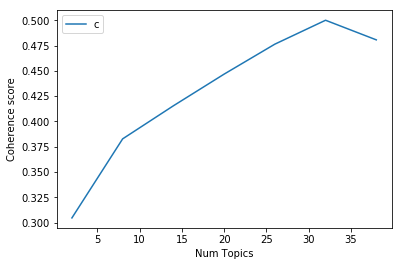

In [273]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [274]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3047
Num Topics = 8  has Coherence Value of 0.3828
Num Topics = 14  has Coherence Value of 0.4155
Num Topics = 20  has Coherence Value of 0.4468
Num Topics = 26  has Coherence Value of 0.4764
Num Topics = 32  has Coherence Value of 0.5
Num Topics = 38  has Coherence Value of 0.4806


In [275]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

2019-12-07 20:01:17,417 : INFO : topic #17 (1.562): 0.060*"great" + 0.040*"build" + 0.040*"leave" + 0.030*"bad" + 0.027*"guess" + 0.020*"book" + 0.017*"similar" + 0.017*"online" + 0.015*"lie" + 0.015*"voltage"
2019-12-07 20:01:17,419 : INFO : topic #28 (1.562): 0.060*"make" + 0.054*"change" + 0.040*"back" + 0.037*"state" + 0.037*"video" + 0.023*"set" + 0.021*"power" + 0.019*"year_ago" + 0.019*"amount" + 0.017*"personally"
2019-12-07 20:01:17,421 : INFO : topic #22 (1.562): 0.069*"day" + 0.067*"fuck" + 0.058*"point" + 0.036*"top" + 0.031*"word" + 0.031*"research" + 0.024*"human" + 0.022*"mind" + 0.022*"bit" + 0.020*"black"
2019-12-07 20:01:17,423 : INFO : topic #23 (1.562): 0.091*"love" + 0.078*"put" + 0.027*"thing" + 0.027*"computer" + 0.023*"support" + 0.023*"read" + 0.021*"stay" + 0.021*"stop" + 0.021*"show" + 0.015*"respect"
2019-12-07 20:01:17,424 : INFO : topic #12 (1.562): 0.212*"people" + 0.033*"idea" + 0.027*"argument" + 0.027*"kind" + 0.022*"law" + 0.020*"choice" + 0.018*"soci

[(17,
  '0.060*"great" + 0.040*"build" + 0.040*"leave" + 0.030*"bad" + 0.027*"guess" '
  '+ 0.020*"book" + 0.017*"similar" + 0.017*"online" + 0.015*"lie" + '
  '0.015*"voltage"'),
 (28,
  '0.060*"make" + 0.054*"change" + 0.040*"back" + 0.037*"state" + '
  '0.037*"video" + 0.023*"set" + 0.021*"power" + 0.019*"year_ago" + '
  '0.019*"amount" + 0.017*"personally"'),
 (22,
  '0.069*"day" + 0.067*"fuck" + 0.058*"point" + 0.036*"top" + 0.031*"word" + '
  '0.031*"research" + 0.024*"human" + 0.022*"mind" + 0.022*"bit" + '
  '0.020*"black"'),
 (23,
  '0.091*"love" + 0.078*"put" + 0.027*"thing" + 0.027*"computer" + '
  '0.023*"support" + 0.023*"read" + 0.021*"stay" + 0.021*"stop" + 0.021*"show" '
  '+ 0.015*"respect"'),
 (12,
  '0.212*"people" + 0.033*"idea" + 0.027*"argument" + 0.027*"kind" + '
  '0.022*"law" + 0.020*"choice" + 0.018*"society" + 0.015*"worry" + '
  '0.013*"happiness" + 0.013*"free"'),
 (11,
  '0.150*"good" + 0.054*"experience" + 0.047*"base" + 0.022*"space" + '
  '0.018*"talk" 

### Find the dominant topic in each sentence 

In [280]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_processed_bigram)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

2019-12-07 20:07:09,273 : INFO : serializing temporary corpus to /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/e7e125_corpus.txt
2019-12-07 20:07:09,303 : INFO : converting temporary corpus to MALLET format with ../../mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/e7e125_corpus.txt --output /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/e7e125_corpus.mallet.infer --use-pipe-from /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/e7e125_corpus.mallet
2019-12-07 20:07:10,794 : INFO : inferring topics with MALLET LDA '../../mallet-2.0.8/bin/mallet infer-topics --input /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/e7e125_corpus.mallet.infer --inferencer /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/e7e125_inferencer.mallet --output-doc-topics /var/folders/pg/8fn4d8f953gg7wnwv3lsjck40000gn/T/e7e125_doctopics.txt.infer --num-iterations 100 --doc-topics-threshold 0.0 -

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,25.0,0.0630,"make, watch, character, kid, sound, drive, jok...","[talos, atom, watch]"
1,1,5.0,0.0587,"work, place, money, hear, answer, class, gover...","[awesome, job, dude, appreciate, hard, work]"
2,2,30.0,0.0639,"give, man, woman, estp, tend, family, accept, ...","[pick, one, shitty, gas, station, near, grand,..."
3,3,15.0,0.0784,"time, pay, hour, company, meet, access, servic...","[never, emotionally, manipulate, steer, people..."
4,4,25.0,0.0730,"make, watch, character, kid, sound, drive, jok...","[catch, mixture, tom, hanks, dicaprio, somethi..."
5,5,16.0,0.0567,"big, test, result, learn, question, interestin...","[even_though, also, browse, sub, fuck, make, s..."
6,6,1.0,0.0483,"understand, user, feeling, model, function, fi...","[play, hero, skill]"
7,7,1.0,0.0471,"understand, user, feeling, model, function, fi...","[understand, agree]"
8,8,11.0,0.0450,"good, experience, base, space, talk, drop, thr...","[ill, look, yeh]"
9,9,27.0,0.0475,"game, play, thing, lot, good, stuff, weird, pa...","[tactical, game, end, though, rollface, everyt..."


### The Most Representative Document for each topic

In [282]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4461,"url, kind, edit, jpg, good, send, review, poor...","[usa, european, sunscreen, much, advanced, lim..."
1,1.0,0.5324,"understand, user, feeling, model, function, fi...","[additional, note, vs, subjective, function, w..."
2,2.0,0.2969,"run, issue, find, problem, sleep, break, fight...","[voice, hear, like, audible, voice, need, take..."
3,3.0,0.5362,"make, bring, great, song, idea, yeah, friend, ...","[yeah, think, know, much, say, flag, bring, st..."
4,4.0,0.3576,"lot, people, gt, reason, talk, hard, kill, rea...","[cold, uncomfortable, discipline, motivation, ..."
5,5.0,0.2743,"work, place, money, hear, answer, class, gover...","[art, institute, bad, short, answer, depend, g..."
6,6.0,0.3751,"year, time, friend, social, couple, crazy, fin...","[see, graduate, less, month, ago, paint, prett..."
7,7.0,0.1674,"turn, fun, plan, look_like, cash, remind, repl...","[raise, interesting, point, may, age, currentl..."
8,8.0,0.2642,"pretty, wait, normal, nope, wow, eye, feminist...","[dog, yellow, lab, ocd, hate, tile, sprint, ti..."
9,9.0,0.2818,"hate, nice, back, hurt, reddit, fair, head, la...","[provide, stability, sense, belong, sense, per..."


### Top distribution across documents

In [284]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,25.0,"make, watch, character, kid, sound, drive, jok...",68.0,0.068
1.0,5.0,"work, place, money, hear, answer, class, gover...",28.0,0.028
2.0,30.0,"give, man, woman, estp, tend, family, accept, ...",36.0,0.036
3.0,15.0,"time, pay, hour, company, meet, access, servic...",28.0,0.028
4.0,25.0,"make, watch, character, kid, sound, drive, jok...",28.0,0.028
...,...,...,...,...
995.0,2.0,"run, issue, find, problem, sleep, break, fight...",NaN,NaN
996.0,2.0,"run, issue, find, problem, sleep, break, fight...",NaN,NaN
997.0,7.0,"turn, fun, plan, look_like, cash, remind, repl...",NaN,NaN
998.0,22.0,"day, fuck, point, top, word, research, human, ...",NaN,NaN


## SpaCy Text Categorizer

#### Prepare the data

In [105]:
import spacy
from spacy.util import minibatch, compounding

In [120]:
# resample the data
data_test = data.sample(n=10000)

# use SKlearn library to encode the labels 
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data_test['label'] = label_encoder.fit_transform(data_test['MBTI'])

In [141]:
data_test

,MBTI,comments_lemma,label
220352,ENFJ,yeah really big deal battery suppose die year ...,0
91150,ISFP,fifth request deposit level female shroomish c...,13
148628,ENTJ,honorary american bring home,2
1783,ENFP,cute response type already decide click profil...,1
915707,ENTP,shit save comment bad idea,3
...,...,...,...
180951,ENFP,usa apparently sporting event,1
54600,ESTP,last good president besides trump,7
890513,INFJ,gt regressive describe distribution effect inc...,8
1118137,INTP,gt relatively vanilla past like choke choking ...,11


In [144]:
data_test['I/E'] = data_test['MBTI'].str[0]
data_test['N/S'] = data_test['MBTI'].str[1]
data_test['T/F'] = data_test['MBTI'].str[2]
data_test['J/P'] = data_test['MBTI'].str[3]

In [145]:
# convert strings to binary classes
IE = {'I':1, 'E':0}
NS = {'N':1, 'S':0}
TF = {'T':1, 'F':0}
JP = {'J':1, 'P':0}

data_test['I/E'] = data_test['I/E'].map(IE)
data_test['N/S'] = data_test['N/S'].map(NS)
data_test['T/F'] = data_test['T/F'].map(TF)
data_test['J/P'] = data_test['J/P'].map(JP)

In [147]:
data_test1 = data_test.drop(['MBTI','label'], axis=1 )

In [149]:
data_test1

,comments_lemma,I/E,N/S,T/F,J/P
220352,yeah really big deal battery suppose die year ...,0,1,0,1
91150,fifth request deposit level female shroomish c...,1,0,0,0
148628,honorary american bring home,0,1,1,1
1783,cute response type already decide click profil...,0,1,0,0
915707,shit save comment bad idea,0,1,1,0
...,...,...,...,...,...
180951,usa apparently sporting event,0,1,0,0
54600,last good president besides trump,0,0,1,0
890513,gt regressive describe distribution effect inc...,1,1,0,1
1118137,gt relatively vanilla past like choke choking ...,1,1,1,0


In [131]:
# get the list of encoding as dictionary
encode_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(encode_name_mapping)

{'ENFJ': 0, 'ENFP': 1, 'ENTJ': 2, 'ENTP': 3, 'ESFJ': 4, 'ESFP': 5, 'ESTJ': 6, 'ESTP': 7, 'INFJ': 8, 'INFP': 9, 'INTJ': 10, 'INTP': 11, 'ISFJ': 12, 'ISFP': 13, 'ISTJ': 14, 'ISTP': 15}


In [124]:
X = data_test.comments_lemma
y = data_test.label



# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

# recombine train and test columns
train_df = pd.concat([y_train, X_train], axis = 1)
test_df = pd.concat([y_test, X_test], axis = 1)

In [126]:
# prepare the data the SpaCy way 
train_df['tuples'] = train_df.apply(lambda x: (x['comments_lemma'], x['label']), axis=1)
train = train_df['tuples'].tolist()
train[:1]

[('understand reference please explain', 2)]

#### Load SpaCy functions 

In [151]:
#nlp = spacy.load('en_core_web_sm') 

In [152]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
    textcat.add_label("I/E")
    textcat.add_label("N/S")
    textcat.add_label("T/F")
    textcat.add_label("J/P")


# load the dataset
print("Loading Reddit data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

ValueError: [E116] Cannot currently add labels to pre-trained text classifier. Add labels before training begins. This functionality was available in previous versions, but had significant bugs that led to poor performance.

In [138]:
# SpaCy functions 
def load_data(limit=0, split=0.8):
    train_data = data_test[:7000]
    test_data = data_test[7000:]
    train_data = train_data.comments_lemma.tolist()
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'I/E': bool(y), "NEGATIVE": not bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

#("Number of texts to train from","t" , int)
n_texts=10000
#You can increase texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=2

#### Train Model 

In [139]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  
0.929	0.943	0.996	0.969
0.737	0.943	0.983	0.963


## FastText 

In [17]:
# load in data
data = pd.read_csv('../../clean_data/token_voc.csv', index_col=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
data = data.dropna()

In [19]:
data.isna().sum()

MBTI              0
comments_lemma    0
dtype: int64

In [20]:
data.shape

(2961190, 2)

In [21]:
# filter out single word lines 
data = data[data['comments_lemma'].str.len() > 4]

In [22]:
data.shape

(2881896, 2)

In [60]:
# create a smaller test set 
data_sample = data.sample(n=50000)

### FastText Classification model 

In [25]:
import fasttext

#### 1. Convert the data to FastText format

In [61]:
# convert input file to FastText format: __label__ sentence 1
from io import StringIO
import csv

col = ['MBTI', 'comments_lemma']

data_sample = data_sample[col]
data_sample['MBTI']=['__label__'+ s for s in data_sample['MBTI']]
#data_sample['comments_lemma']= data_sample['comments_lemma'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
data_sample.to_csv(r'fasttextsample.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [31]:
data_sample.head()

,MBTI,comments_lemma
264497,__label__ISTP,yet see moon big remember without photo zoom p...
439434,__label__INFJ,well grandma would stop axe wield german cop
69782,__label__ISTP,pip pip cheerio big ben yellow tooth
16947,__label__ISFP,go comment situation declaw cat unquestionably...
28278,__label__ISTJ,believe watch angriest long time never complai...


In [32]:
data_sample.tail()

,MBTI,comments_lemma
462132,__label__INFJ,suggest poke adc provide lot benefit adc suppo...
931,__label__ENFJ,early year college
614180,__label__INFP,lepsy
7848,__label__ESFJ,sound like much skin irritate would suggest st...
9154,__label__ESFJ,type nostalgic sort thing maybe possible witho...


In [62]:
# split the data to two files
from sklearn.model_selection import train_test_split

X = data_sample.comments_lemma
y = data_sample.MBTI

X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, test_size = 0.3, stratify=y_rest, random_state=42)

In [63]:
train_df = pd.concat([y_train, X_train], axis = 1)
valid_df = pd.concat([y_valid, X_valid], axis = 1)
test_df = pd.concat([y_test, X_test], axis = 1)
train_df.to_csv(r'fasttextsample_train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
valid_df.to_csv(r'fasttextsample_valid.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
test_df.to_csv(r'fasttextsample_test.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

#### Input the data into the model

In [68]:
#  train the model 
# adjust epochs
epochs = range(1,51)
test_scores = []

for epoch in epochs: 
    model = fasttext.train_supervised(input='fasttextsample_train.txt', epoch = epoch, lr= 1.0, 
                                      wordNgrams = 2, bucket = 200000, dim=50, loss='hs')
    score = model.test('fasttextsample_valid.txt')[1]
    test_scores.append(score)

    

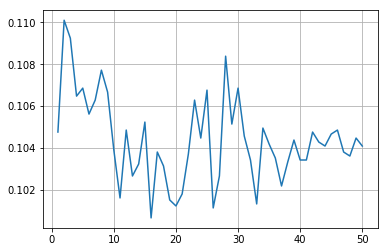

In [72]:
plt.figure()
plt.plot(epochs, test_scores)
plt.grid()
plt.show()

In [74]:
# adjust learning rate

learning_rates = np.arange(0.1,1.0,0.1)
test_scores = []

for learning_rate in learning_rates: 
    model = fasttext.train_supervised(input='fasttextsample_train.txt', epoch = 2, lr= learning_rate, 
                                      wordNgrams = 2, bucket = 200000, dim=50, loss='hs')
    score = model.test('fasttextsample_valid.txt')[1]
    test_scores.append(score)

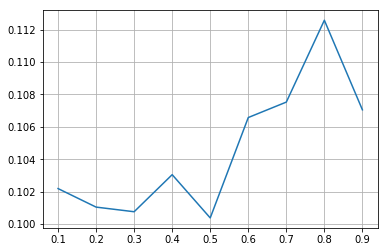

In [75]:
plt.figure()
plt.plot(learning_rates, test_scores)
plt.grid()
plt.show()

In [77]:
# final model 
model = fasttext.train_supervised(input='fasttextsample_train.txt', epoch = 2, lr= 0.8, 
                                      wordNgrams = 2, bucket = 200000, dim=50, loss='hs')
# save the model 
model.save_model('fasttext_model.bin')

In [78]:
# test on test set 
model.test('fasttextsample_test.txt')

(15000, 0.10786666666666667, 0.10786666666666667)

### Word Representation

In [80]:
# convert column to list 
documents = data_sample['comments_lemma'].tolist()
# tokenize the text
texts = [[text for text in doc.split()] for doc in documents]

In [91]:
# train word vectors
model1 = fasttext.train_unsupervised('fasttextsample_train.txt', 'skipgram', minn=2, maxn=10, dim=300)

In [90]:
model1.words

['</s>',
 'like',
 'get',
 'would',
 'think',
 'people',
 'go',
 'make',
 'one',
 'say',
 'know',
 'good',
 'thing',
 'time',
 'really',
 'well',
 'see',
 'want',
 'use',
 'way',
 'even',
 'also',
 'url',
 'much',
 'look',
 'take',
 'feel',
 'work',
 'could',
 'try',
 'something',
 'need',
 'may',
 'gt',
 'lot',
 'find',
 'mean',
 'still',
 'though',
 'come',
 'right',
 'give',
 'actually',
 'someone',
 'game',
 'year',
 'pretty',
 'love',
 'first',
 'never',
 'life',
 'sure',
 'day',
 'type',
 'bad',
 'point',
 'seem',
 'play',
 'friend',
 'back',
 'tell',
 'probably',
 'start',
 'talk',
 'help',
 'always',
 'person',
 'thank',
 'yeah',
 'great',
 'many',
 'anything',
 'keep',
 'guy',
 'around',
 'new',
 'kind',
 'happen',
 'read',
 'every',
 'maybe',
 'different',
 'post',
 'part',
 'problem',
 'man',
 'two',
 'change',
 'ask',
 'end',
 'since',
 'long',
 'sound',
 'idea',
 'shit',
 'little',
 'call',
 'put',
 'let',
 'show',
 'hard',
 'stuff',
 'high',
 'reason',
 'everyone',
 'watc

In [94]:
[model1.get_word_vector(x) for x in ['people', 'time']]

[array([-0.09537304,  0.3561909 , -0.08850993, -0.24127467,  0.11556696,
        -0.20370804,  0.11027719,  0.06987511,  0.02689176,  0.03246935,
        -0.02068891, -0.18130045,  0.04461755, -0.17109111, -0.19581634,
         0.11425466,  0.07769009,  0.02296423,  0.04413997, -0.13937744,
        -0.05166119, -0.04559472,  0.06833678, -0.14657412, -0.14957972,
         0.03565238, -0.06352694,  0.25479218, -0.09033816,  0.18298495,
        -0.04188045,  0.1409752 , -0.07972287,  0.20934802, -0.12069701,
        -0.06939403, -0.0254754 ,  0.03402642,  0.01115112,  0.18370035,
        -0.14062482,  0.01167719,  0.05063783,  0.02637454, -0.05648021,
        -0.08986854, -0.00140474, -0.02310129,  0.01793243,  0.01749393,
        -0.17947817,  0.0276182 , -0.00152708, -0.28967345, -0.0477215 ,
        -0.03293296,  0.06526383, -0.04880449,  0.1924236 , -0.04642263,
         0.10377389,  0.06817944,  0.04381724,  0.13850628, -0.06063931,
        -0.04906886, -0.20331122, -0.02131415, -0.0

## Improved Models

In [155]:
data_test = data_test[['MBTI','comments_lemma', 'label']].copy()

In [156]:
data_test

,MBTI,comments_lemma,label
220352,ENFJ,yeah really big deal battery suppose die year ...,0
91150,ISFP,fifth request deposit level female shroomish c...,13
148628,ENTJ,honorary american bring home,2
1783,ENFP,cute response type already decide click profil...,1
915707,ENTP,shit save comment bad idea,3
...,...,...,...
180951,ENFP,usa apparently sporting event,1
54600,ESTP,last good president besides trump,7
890513,INFJ,gt regressive describe distribution effect inc...,8
1118137,INTP,gt relatively vanilla past like choke choking ...,11


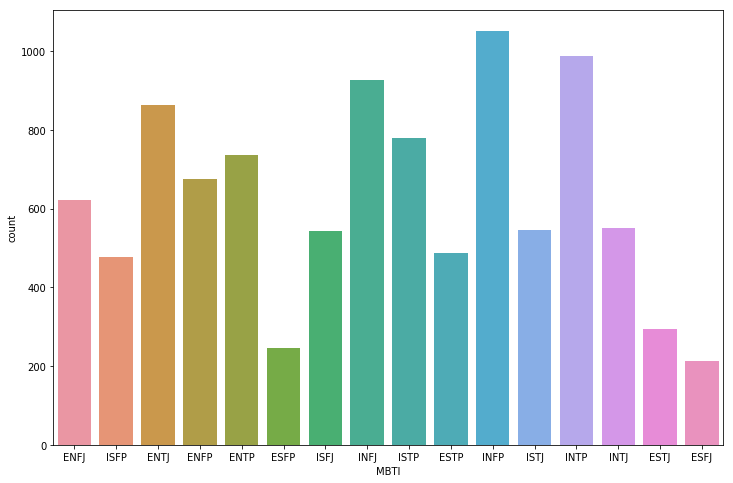

In [216]:
plt.figure(figsize=(12,8))
sns.countplot(data=data_test, x=data_test.MBTI)
plt.show()

In [217]:
data_test['comments_lemma'].apply(lambda x: len(x.split(' '))).sum()

199844

In [168]:
personality_id_df = data_test[['MBTI', 'label']].drop_duplicates().sort_values('label').reset_index(drop=True)

In [169]:
personality_id_df

,MBTI,label
0,ENFJ,0
1,ENFP,1
2,ENTJ,2
3,ENTP,3
4,ESFJ,4
5,ESFP,5
6,ESTJ,6
7,ESTP,7
8,INFJ,8
9,INFP,9


In [317]:
# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data_test.comments_lemma).toarray()

labels = data_test.label

features.shape

AttributeError: 'list' object has no attribute 'lower'

In [316]:
# Most Correlated terms of each MBTI

from sklearn.feature_selection import chi2

import numpy as np

N = 2
mbti_to_label = dict(personality_id_df.values)

for personality, lb in sorted(mbti_to_label.items()):
    features_chi2 = chi2(features, labels == lb)
    indices = np.argsort(features_chi2[0])
    
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("# '{}':".format(personality))
    
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

IndexError: index 4788 is out of bounds for axis 0 with size 3913

### Classifier 

#### Naive Bayes

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(data_test['comments_lemma'], data_test['MBTI'], random_state = 42)
X_train_tfidf = tfidf.fit_transform(X_train)

mynb = MultinomialNB().fit(X_train_tfidf, y_train)

In [200]:
X_test_tfidf = tfidf.transform(X_test)

In [201]:
y_pred = mynb.predict(X_test_tfidf)

In [206]:
print('Accuracy Score: ', mynb.score(X_test_tfidf, y_test))
print(classification_report(y_test, y_pred))

Accuracy Score:  0.1176
              precision    recall  f1-score   support

        ENFJ       0.20      0.01      0.02       160
        ENFP       0.12      0.01      0.02       158
        ENTJ       0.09      0.09      0.09       223
        ENTP       0.17      0.03      0.05       199
        ESFJ       0.00      0.00      0.00        53
        ESFP       0.00      0.00      0.00        65
        ESTJ       0.00      0.00      0.00        66
        ESTP       0.00      0.00      0.00       119
        INFJ       0.11      0.20      0.15       239
        INFP       0.11      0.50      0.18       259
        INTJ       0.33      0.01      0.01       137
        INTP       0.12      0.26      0.16       243
        ISFJ       0.00      0.00      0.00       119
        ISFP       0.00      0.00      0.00       121
        ISTJ       1.00      0.01      0.01       150
        ISTP       0.21      0.12      0.15       189

   micro avg       0.12      0.12      0.12      2500
  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Compare Different models 

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [210]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

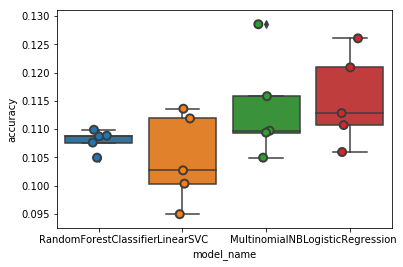

In [211]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [212]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.104700
LogisticRegression        0.115296
MultinomialNB             0.113685
RandomForestClassifier    0.108002
Name: accuracy, dtype: float64

In [297]:
# the best model 
model = LogisticRegression()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data_test.index, test_size=0.3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


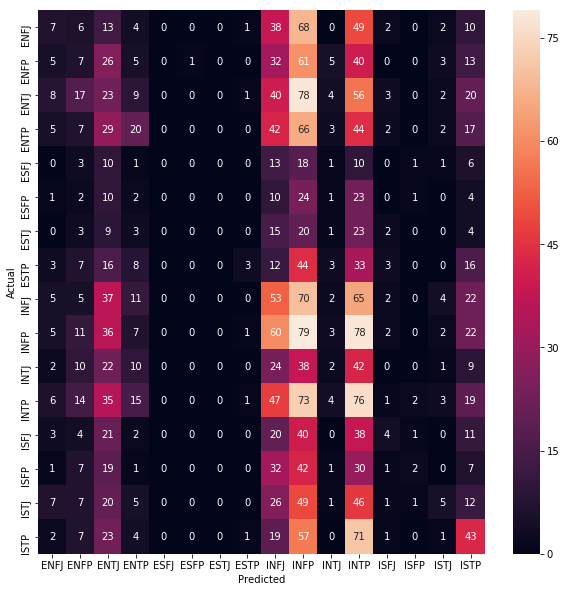

In [214]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=personality_id_df.MBTI.values, yticklabels=personality_id_df.MBTI.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Doc2Vec

In [231]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")


import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

/anaconda3/lib/python3.7/site-packages/tqdm/std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Prepare and Tagging the data 

In [225]:
data_test['comments_lemma'] = [[text for text in doc.split()] for doc in data_test['comments_lemma']]

In [226]:
# use the above test set 
train, test = train_test_split(data_test, test_size=0.3, random_state=42)


In [241]:
# prepare the tagged data
train_tagged = train.apply(lambda x: TaggedDocument(words = x['comments_lemma'], tags = [x['MBTI']]), axis=1)

test_tagged = test.apply(lambda x: TaggedDocument(words = x['comments_lemma'], tags = [x['MBTI']]), axis=1)
train_tagged.values[100]

TaggedDocument(words=['another', 'cultural', 'difference', 'work', 'french', 'people', 'offend', 'swear', 'word', 'many', 'people', 'putain', 'equivalent', 'fuck', 'although', 'literal', 'translation', 'whore', 'basically', 'use', 'punctuation', 'mark', 'course', 'proper', 'improper', 'way', 'speak', 'use', 'many', 'swear', 'word', 'give', 'bad', 'impression', 'overall', 'sensitivity', 'less', 'america'], tags=['ISFP'])

### Set up Doc2Vec  training and evaluation models

#### DBOW model

In [236]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [242]:
# building a vocabulary 
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 7000/7000 [00:00<00:00, 1394912.96it/s]


In [245]:
## Initialize the model and train for 30 epochs 
from sklearn import utils

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 7000/7000 [00:00<00:00, 1259010.63it/s]


In [247]:
# build the final vector feature for the classifier 

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [248]:
# train LogReg 
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.07733333333333334
Testing F1 score: 0.07283090376591186


#### Distributed Memory 

In [249]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 7000/7000 [00:00<00:00, 1201511.21it/s]


In [250]:
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 7000/7000 [00:00<00:00, 1219882.33it/s]


In [251]:
# train the log reg 
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.07466666666666667
Testing F1 score: 0.07935427035202683


#### Model Pairing 


In [252]:
# delete temp training data to free up RAM

model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [254]:
# Concat 2 models 
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [255]:
# Building Feature vectors 
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [256]:
# train log reg 
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.06766666666666667
Testing F1 score: 0.06728712147639444


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## LSTM Modelling

### Import Keras

In [276]:
# import Keras 

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, SpatialDropout1D, LSTM
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping
from keras import utils

### Prepare Data

In [262]:
# use the same test data above 


# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100


tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_test.comments_lemma.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21099 unique tokens.


In [265]:
# Truncate and pad the input sequenes 
X = tokenizer.texts_to_sequences(data_test.comments_lemma.values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10000, 250)


In [266]:
# convert categorical labels to numbers 
Y = pd.get_dummies(data_test.MBTI).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10000, 16)


In [267]:
# train test split 

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9000, 250) (9000, 16)
(1000, 250) (1000, 16)


### Build Layers

In [277]:

model = Sequential()
# Embedded Layers, can use external library like GloVe
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])) 
# variational dropout
model.add(SpatialDropout1D(0.2))
# LSTM with 100 memory units
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# output layer, 16 total output, one for each class, activation is softmax
model.add(Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 8100 samples, validate on 900 samples
Epoch 1/5
8100/8100 [==============================] - 113s 14ms/step - loss: 2.7052 - accuracy: 0.0994 - val_loss: 2.7019 - val_accuracy: 0.1122
Epoch 2/5
8100/8100 [==============================] - 139s 17ms/step - loss: 2.6704 - accuracy: 0.1279 - val_loss: 2.7035 - val_accuracy: 0.1022
Epoch 3/5
8100/8100 [==============================] - 109s 14ms/step - loss: 2.5121 - accuracy: 0.2302 - val_loss: 2.7685 - val_accuracy: 0.1011
Epoch 4/5
8100/8100 [==============================] - 124s 15ms/step - loss: 2.0167 - accuracy: 0.4052 - val_loss: 2.9713 - val_accuracy: 0.0944


In [278]:
# evaluate on the test set 

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1000/1000 [==============================] - 3s 3ms/step
Test set
  Loss: 2.996
  Accuracy: 0.096


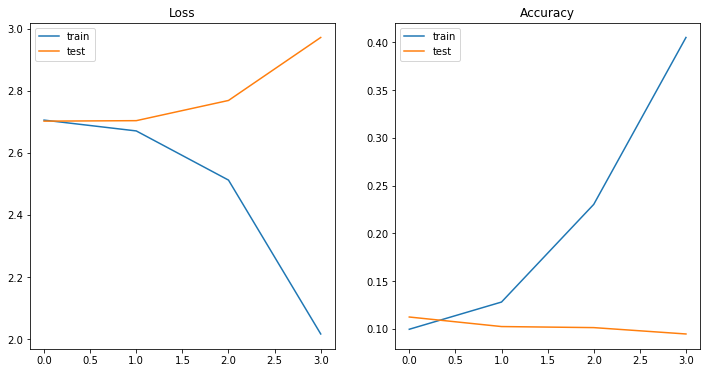

In [285]:
# Plot out the Loss 
plt.subplots(1,2, figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

plt.show()

## Multiple Output

In [311]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Split mbti personality into 4 letters and binarize
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 

# convert MBTI to 4 binary classification 
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    '''
    transform mbti to binary vector
    '''
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    '''
    transform binary vector to mbti personality
    '''
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data_test.MBTI])
print("Binarize MBTI list: \n%s" % list_personality_bin)


Binarize MBTI list: 
[[1 0 0 0]
 [0 1 0 1]
 [1 0 1 0]
 ...
 [0 0 0 0]
 [0 0 1 1]
 [0 0 0 0]]


In [312]:
# Feed classifier to MultiOutputCLassifier

clf = AdaBoostClassifier()
multi_target_classifier = MultiOutputClassifier(clf, n_jobs=-1)
multi_target_classifier.fit(X_tfidf, list_personality_bin)
preds = multi_target_classifier.predict(X_tfidf)

preds_t = [translate_back(p) for p in preds]
vec1 = data_test.MBTI ==  preds_t
for i in range(4):
    print("f1 score for %s:\n%s" % (titles[i],
                                    f1_score(np.array(list_personality_bin)[:,i], preds[:,i])))

f1 score for Extraversion (E) - Introversion (I):
0.0024102193299590257
f1 score for Sensation (S) - INtuition (N):
0.0
f1 score for Thinking (T) - Feeling (F):
0.6687806284231766
f1 score for Judgement (J) - Perception (P):
0.6919418019026302


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [314]:
# Stratified cross val for multi-output
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

X = list_posts
y = np.array(list_personality_bin)

clf = AdaBoostClassifier()

kf = StratifiedShuffleSplit(n_splits=4)

list_score = []
list_score_per_class= []

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

X_train = tfidfizer.fit_transform(X_train).toarray()
X_test = tfidfizer.transform(X_test).toarray()

multi_target_classifier = MultiOutputClassifier(clf, n_jobs=-1)
multi_target_classifier.fit(X_train, y_train)
preds = multi_target_classifier.predict(X_test)

rev_preds = np.array([translate_back(p) for p in preds]) 
rev_test = np.array([translate_back(p) for p in y_test])
score = f1_score(rev_test,rev_preds, average='weighted')
list_score.append(score)
print('\nTotal score: %s' % f1_score(rev_test,rev_preds, average='weighted'))

list_temp =[]
for i in range(4):
    score_per_class = f1_score(y_test[:,i], preds[:,i])
    list_temp.append(score_per_class)
    print(score_per_class)
list_score_per_class.append(list_temp)



Total score: 0.03599502398248623
0.0
0.0
0.6463054187192119
0.6924961033177467


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
